# Week 2 assignments 
**Please do the assignments using the `mlops_eng` environment.**

In this week's assignments, you will practice data cleaning and validation, feature extraction, and feature engineering. You will use Pandas to write scripts to automate the data wrangling parts and [Great Expectations](https://greatexpectations.io/) for data validation.

**Guidelines for submitting assignments**:
- For each assignment, a code skeleton is provided. Please put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments. Please **do not change any code other than those between the `### START CODE HERE` and `### END CODE HERE` comments**. Otherwise your notebook may not pass the tests used in grading.
- Some assignments also require you to capture screenshots in order to earn points. Please put all your answers and the required screenshots into a single PDF file. For each screenshot, please clearly indicate which assignment it corresponds to in your PDF file. 
- When preparing your submission, be sure to include this assignment notebook. In the last assignment, you will need to modify a Python script named `etl.py`. Besides this assignment notebook, please also include `etl.py` in your submission. 

Import all the packages needed in the assignments and set global variables.

In [1]:
import pickle
import os
from pathlib import Path
from typing import Tuple, List, Optional
import logging
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import great_expectations as gx

from IPython.display import display

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import TargetEncoder

from thefuzz import fuzz, process

from great_expectations.data_context import EphemeralDataContext, FileDataContext
from great_expectations.datasource.fluent import BatchRequest
from great_expectations.exceptions import DataContextError
from great_expectations.expectations.expectation import Expectation
from great_expectations.checkpoint.types.checkpoint_result import CheckpointResult
from great_expectations.checkpoint import Checkpoint

from test_helper import series_approximately_same

# Set the random seed to ensure the assignments are reproducible
RANDOM_SEED = 42

# Path to the current working directory
WORKING_DIR = Path.cwd()


In [2]:
# This function is for the grading purpose only
def is_being_graded():
    """
    Returns True if the notebook is being executed by the auto-grading tool.
    """
    env = os.environ.get("NBGRADER_EXECUTION")
    return env == "autograde" or env == "validate"


# Suppress loggings and warnings when grading the notebook
if is_being_graded():
    loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
    for logger in loggers:
        logger.setLevel(logging.ERROR)
    warnings.filterwarnings('ignore')

## Assignment 1: Data extraction (2 points)
We will be working with a synthetic housing price dataset (based on [this](https://www.kaggle.com/datasets/htagholdings/property-sales) and [this](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction) dataset), which lists house prices at the Canberra area in Australia from 2009 to 2016. The data description is provided in the file [Data_description.csv](./Data_description.csv). We will use this dataset to train a regression model to predict prices of houses given some info about the houses. 

### 1a) Load the data
Let's first load the training dataset, which consists of two files. The file `deals.csv` holds the price information for the sold houses along with some minor information about the houses. The file `house_info.json` has more detailed information about the houses. Complete the function `file_reader` that loads both files into Pandas DataFrames. 

Hint: The `.json` file is saved in a "list-like" format, so we need to use parameter "`orient='records'`" when use Pandas to read the JSON file.

In [3]:
def file_reader(path: Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Read files of deals and house information into DataFrames
    Args:
        path (Path): Path to the folder where the files exist.
    Returns:
        a tuple consisting of a Pandas DataFrame of deals and a Pandas DataFrame of house information
    """
    
    price_file_path = path / "deals.csv"
    house_file_path = path / "house_info.json" 

    ### START CODE HERE
    # Load CSV file into DataFrame
    deals_df = pd.read_csv(price_file_path)
    
    # Load JSON file into DataFrame with orient='records' since it’s in a list-like format
    house_info_df = pd.read_json(house_file_path, orient='records')
    
    return deals_df, house_info_df
    ### END CODE HERE


Now, run the cell below to call the function you just created. Let's take a quick look at the DataFrames.

In [4]:
train_path = WORKING_DIR / "data" / "reference" / "train"
prices, house_data = file_reader(train_path)

assert prices.shape == (11046, 6), "The shape of the price DataFrame is incorrect."
assert house_data.shape == (
    11046,
    20,
), "The shape of the house_data DataFrame is incorrect."

assert sorted(prices.columns) == sorted(
    ["datesold", "price", "building_year", "bedrooms", "postcode", "area"]
), "The columns of the price DataFrame are incorrect."

assert sorted(house_data.columns) == sorted(
    [
        "date",
        "postcode",
        "area",
        "bedrooms",
        "bathrooms",
        "yr_built",
        "yr_renovated",
        "condition",
        "grade",
        "floors",
        "sqft_living",
        "sqft_lot",
        "sqft_above",
        "sqft_basement",
        "sqft_living15",
        "sqft_lot15",
        "waterfront",
        "view",
        "distance",
        "prev_owner",
    ]
), "The columns of the house_data DataFrame are incorrect."

In [5]:
display(prices.head())
display(house_data.head())

,datesold,price,building_year,bedrooms,postcode,area
0,01-April-2009,437100,1977,4,2906,Conder
1,01-April-2009,461300,1969,4,2615,Kippax Centre
2,01-April-2009,280900,1966,3,2615,Higgins
3,01-April-2009,351600,1978,3,2620,Tinderry
4,01-April-2009,431300,2005,3,2914,Bonner


,date,postcode,area,bedrooms,bathrooms,yr_built,yr_renovated,condition,grade,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,waterfront,view,distance,prev_owner
0,2011-10-24,2906,Gordon,4,3.00,1997,NaN,Satisfactory,9,2.0,2875,13413,2875,0,2765.0,13500.0,0,0,20.10,Gregory
1,2010-10-02,2605,Curtin,4,2.00,1927,NaN,Good,8,2.0,2450,5346,1940,510,2200.0,5535.0,0,0,7.62,Barrett
2,2015-09-25,2615,Macgregor,3,1.75,1976,NaN,Satisfactory,7,1.0,1735,8048,1235,500,1734.0,7649.0,0,0,13.04,Bowman
3,2011-11-03,2906,Banks,4,2.00,1977,NaN,Satisfactory,8,1.0,2555,12448,1585,970,2341.0,10026.0,0,0,21.40,Wilson
4,2014-12-16,2914,Bonner,3,2.50,2004,NaN,Satisfactory,8,2.5,1590,1750,1410,180,1588.0,2120.0,0,0,14.01,Allen


It seems that both DataFrames share a date column as well as four other columns (building year, number of bedrooms, postcode and area), so we can use these columns to merge the datasets into one. To be able to do so, we need to make sure the column names and types are same in both DataFrames.

### 1b) Check column types
Let's first check the data type of the shared columns. Complete the `show_col_dtype` function that returns the dtype of a given column of a given DataFrame.

In [6]:
def show_col_dtype(df: pd.DataFrame, col_name: str) -> str:
    """
    Print the dtype of a column of a DataFrame
    Args:
        df (DataFrame): The DataFrame whose column needs to be checked
        col_name(str): the name of the column to be checked
    Returns:
        Column type name as a string
    """
    ### START CODE HERE
    # Get the data type of the specified column and convert it to a string
    col_dtype = str(df[col_name].dtype)
    return col_dtype
    ### END CODE HERE

In [7]:
assert show_col_dtype(prices, "datesold") == "object", "The dtype of the datesold column in the prices DataFrame is not correctly returned."
assert show_col_dtype(house_data, "date") == "datetime64[ns]", "The dtype of the date column in the house_data DataFrame is not correctly returned."

In [8]:
def print_dtype_helper(df: pd.DataFrame, col_name: str):
    """
    Print the dtype of a column of a DataFrame
    Args:
        df (DataFrame): The DataFrame whose column needs to be checked
        col_name(str): the name of the column to be checked
    """
    print(f"The dtype of the {col_name} column is {show_col_dtype(df, col_name)}")

# date column
print_dtype_helper(prices, "datesold")
print_dtype_helper(house_data, "date")

# building year column
print_dtype_helper(prices, "building_year")
print_dtype_helper(house_data, "yr_built")

# bedroom number column
print_dtype_helper(prices, "bedrooms")
print_dtype_helper(house_data, "bedrooms")

# postcode column
print_dtype_helper(prices, "postcode")
print_dtype_helper(house_data, "postcode")

# area column
print_dtype_helper(prices, "area")
print_dtype_helper(house_data, "area")


The dtype of the datesold column is object
The dtype of the date column is datetime64[ns]
The dtype of the building_year column is int64
The dtype of the yr_built column is int64
The dtype of the bedrooms column is int64
The dtype of the bedrooms column is int64
The dtype of the postcode column is int64
The dtype of the postcode column is int64
The dtype of the area column is object
The dtype of the area column is object


From the output, you should see that only the date columns have different dtypes:

The dtype of column datesold is: object 

The dtype of column date is: datetime64[ns] 

### 1c) Merge price and house_data DataFrames
Now, it seems that only the column `datesold` needs to be converted to datetime format. Additionally, one of the building year columns needs to be renamed to the same as the other one. Do the following in the `dataframe_merge` function:
1. Convert the `datesold` column in the price DataFrame into `panda.datetime` format and store it in a new column named 'date' in the same DataFrame. (Do not delete the `datesold` column for now.)
1. Rename the column `building_year` to `yr_built` in the price DataFrame.
1. Merge the DataFrames using columns `date`, `postcode`, `bedrooms`, `area` and `yr_built` as keys.

The following functions may be helpful:
- [pandas.to_datetime](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.to_datetime.html)
- [pandas.DataFrame.rename](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.DataFrame.rename.html)
- [pandas.merge](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.DataFrame.merge.html)

NOTE: _In reality, we could not rely on these 5 columns to form a unique indicator for the merge to succeed. However, in the scope of this exercise we know a priori that this property holds for our data._  

In [9]:
def dataframe_merger(prices: pd.DataFrame, house_data: pd.DataFrame) -> pd.DataFrame:
    """
    Merge the two DataFrames given as inputs
    Args:
        prices (DataFrame): A pandas DataFrame holding the price information
        house_data (DataFrame): A pandas DataFrame holding the detailed information about the sold houses
    Returns:
        The merged pandas DataFrame
    """

    ### START CODE HERE
    # Step 1: Convert `datesold` column to datetime format and store it in a new column named `date`
    prices['date'] = pd.to_datetime(prices['datesold'])
    
    # Step 2: Rename `building_year` to `yr_built` in the `prices` DataFrame
    prices = prices.rename(columns={'building_year': 'yr_built'})
    
    # Step 3: Merge the two DataFrames using the specified columns as keys
    merged_df = pd.merge(
        prices, 
        house_data, 
        how='inner', 
        left_on=['date', 'postcode', 'bedrooms', 'area', 'yr_built'],
        right_on=['date', 'postcode', 'bedrooms', 'area', 'yr_built']
    )
    
    return merged_df
    ### END CODE HERE

In [10]:
train_df = dataframe_merger(prices, house_data)
assert train_df.shape == (11046, 22), "The shape of the merged DataFrame is incorrect."
assert sorted(train_df.columns) == sorted(
    [
        "datesold",
        "price",
        "yr_built",
        "bedrooms",
        "postcode",
        "area",
        "date",
        "bathrooms",
        "yr_renovated",
        "condition",
        "grade",
        "floors",
        "sqft_living",
        "sqft_lot",
        "sqft_above",
        "sqft_basement",
        "sqft_living15",
        "sqft_lot15",
        "waterfront",
        "view",
        "distance",
        "prev_owner",
    ]
), "The columns of the merged DataFrame are incorrect."
assert (
    show_col_dtype(train_df, "date") == "datetime64[ns]"
), "The dtype of the date column in the merged DataFrame is incorrect."

In [11]:
# Take a look at the merged DataFrame
display(train_df.head())

,datesold,price,yr_built,bedrooms,postcode,area,date,bathrooms,yr_renovated,condition,...,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,waterfront,view,distance,prev_owner
0,01-April-2009,437100,1977,4,2906,Conder,2009-04-01,2.50,NaN,satisfactory,...,2280,8694,1380,900,1877.0,8052.0,0,0,20.14,Bailey
1,01-April-2009,461300,1969,4,2615,Kippax Centre,2009-04-01,2.25,NaN,Satisfactory,...,2220,14833,1610,610,2202.0,12620.0,0,0,11.74,Buckley
2,01-April-2009,280900,1966,3,2615,Higgins,2009-04-01,1.25,NaN,Satisfactory,...,1130,8867,1130,0,1466.0,8594.0,0,0,10.90,Morgan
3,01-April-2009,351600,1978,3,2620,Tinderry,2009-04-01,2.00,NaN,Satisfactory,...,1800,11431,1420,380,2032.0,11044.0,0,0,9.48,Cumming
4,01-April-2009,431300,2005,3,2914,Bonner,2009-04-01,2.00,NaN,Satisfactory,...,1795,2248,1635,160,1784.0,2714.0,0,0,13.02,Roberts


## Assignment 2: Data cleaning (2 points)
### 2a) Missing values
We have successfully extracted our data, we need to do some cleaning. By now we've noticed there are missing values in some columns. Let's start by checking which columns contain missing values.

In [12]:
print(train_df.isnull().sum())

datesold             0
price                0
yr_built             0
bedrooms             0
postcode             0
area                 0
date                 0
bathrooms            0
yr_renovated     11045
condition            0
grade                0
floors               0
sqft_living          0
sqft_lot             0
sqft_above           0
sqft_basement        0
sqft_living15      135
sqft_lot15        1079
waterfront           0
view                 0
distance             0
prev_owner           0
dtype: int64


The column `yr_renovated` contains $\frac{11045}{11046}$ missing values. With such a high fraction, it is not likely that any imputation scheme would result in a usable feature. So let's just drop that column as useless. While we're at it, we might also drop some other columns as well: 
- The name of the previous owner will not help in our prediction task, so the column `prev_owner` can be dropped as well. 
- The column `datesold` contains redundant duplicate information (the same info is included in the column `date`), so we won't need that either. 
- The values in the `sqft_living` column represent the summation of the values in the `sqft_above` and `sqft_basement` columns, so any one of the `sqft_above` and `sqft_basement` columns is individually redundant.

The columns `sqft_living15` and `sqft_lot15` have roughly only 1.5% and 10% of values missing respectively so we'll be able to use them. We will deal with the missing values in these columns later in the feature engineering part.

Remove the four columns `yr_renovated`, `prev_owner`, `datesold`, and `sqft_above` from our DataFrame.

In [13]:
def drop_futile_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes unneeded columns from the argument DataFrame
    Args:
        df (DataFrame): A pandas DataFrame holding all of the housing data
    Returns:
        The pandas DataFrame with the columns listed in the instruction removed
    """

    ### START CODE HERE
    # Define the columns to drop
    columns_to_drop = ['yr_renovated', 'prev_owner', 'datesold', 'sqft_above']
    
    # Drop the columns and return the resulting DataFrame
    df = df.drop(columns=columns_to_drop)
    
    return df
    ### END CODE HERE

Run the cell below to see if our function works and the columns are indeed dropped. At this point, we should have 18 columns remaining.

In [14]:
df_with_columns_dropped = drop_futile_columns(train_df)

assert df_with_columns_dropped.shape == (
    11046,
    18,
), "The shape of the DataFrame is incorrect after dropping columns."
assert sorted(df_with_columns_dropped.columns) == sorted(
    [
        "price",
        "yr_built",
        "bedrooms",
        "postcode",
        "area",
        "date",
        "bathrooms",
        "condition",
        "grade",
        "floors",
        "sqft_living",
        "sqft_lot",
        "sqft_basement",
        "sqft_living15",
        "sqft_lot15",
        "waterfront",
        "view",
        "distance",
    ]
), "The columns of the DataFrame are incorrect after dropping columns."

### 2b) Inconsistent entries

It's very common for the extracted data to contain inconsistencies. Let's take a closer look at our columns to see if we can spot some.

In [15]:
display(df_with_columns_dropped.describe())

,price,yr_built,bedrooms,postcode,date,bathrooms,grade,floors,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,waterfront,view,distance
count,1.104600e+04,11046.000000,11046.000000,11046.000000,11046,11046.000000,11046.000000,11046.000000,11046.000000,11046.000000,11046.000000,10911.000000,9967.000000,11046.000000,11046.000000,11046.000000
mean,5.925457e+05,1972.844197,3.526073,2747.149285,2012-12-03 18:05:48.071700224,2.213064,8.171103,1.553639,2348.855694,12675.191744,270.469853,2299.625516,11184.507776,0.000272,0.014938,147.499479
min,5.090000e+04,1900.000000,0.000000,2600.000000,2007-07-02 00:00:00,1.000000,6.000000,1.000000,720.000000,1167.000000,0.000000,1208.000000,1404.000000,0.000000,0.000000,0.000000
25%,4.458000e+05,1961.000000,3.000000,2611.000000,2011-02-18 00:00:00,2.000000,7.000000,1.000000,1795.000000,5837.250000,10.000000,1828.000000,5656.500000,0.000000,0.000000,8.080000
50%,5.366000e+05,1977.000000,3.000000,2617.000000,2013-05-03 12:00:00,2.000000,8.000000,1.500000,2220.000000,9357.000000,130.000000,2176.000000,8905.000000,0.000000,0.000000,11.225000
75%,6.613000e+05,1992.000000,4.000000,2905.000000,2014-11-18 00:00:00,2.500000,9.000000,2.000000,2780.000000,14005.750000,470.000000,2683.000000,12701.000000,0.000000,0.000000,13.990000
max,7.989300e+06,2015.000000,5.000000,2914.000000,2015-12-24 00:00:00,5.000000,12.000000,3.000000,8640.000000,482350.000000,2280.000000,4612.000000,182404.000000,1.000000,4.000000,22210.000000
std,2.554195e+05,27.100996,0.695975,148.665660,NaN,0.489251,1.066406,0.450539,706.753347,15545.277547,306.938218,593.615570,10507.371020,0.016479,0.211600,1340.088375


This gives us an overview of all numerical data in the form of some statistics. In general, everything else seems to be in order, but the column `distance` seems to have some extremely high values. The data description says that this column tells the distance from the city center in km, so the max value of 22210.0 is clearly wrong. Let's take a further look at this column. Run the cell below:

In [16]:
df_low = df_with_columns_dropped[df_with_columns_dropped["distance"] < 100]
df_high = df_with_columns_dropped[df_with_columns_dropped["distance"] >= 100]
print(f"df_low ({len(df_low.index)} rows):{df_low['distance'].describe()}")
print(f"\ndf_high ({len(df_high.index)} rows):{df_high['distance'].describe()}")

df_low (10912 rows):count    10912.000000
mean        11.088641
std          4.907516
min          0.000000
25%          7.967500
50%         11.160000
75%         13.880000
max         45.680000
Name: distance, dtype: float64

df_high (134 rows):count      134.000000
mean     11255.820896
std       4825.372992
min        860.000000
25%       8377.500000
50%      10970.000000
75%      13757.500000
max      22210.000000
Name: distance, dtype: float64


It seems there are 134 rows where the distance has been stated in metres instead of kilometers. Complete the `correct_distance_unit` function that changes those values into kilometers. 

**Note**: In this and some other upcoming assignments, you'll need to create functions that manipulate a DataFrame, such as changing the type, values of a column or adding some new columns. As you'll see, a DataFrame will be passed as an argument to the functions. To help you debug your code more easily, please apply your modifications to the copy of the DataFrame rather than directly changing the DataFrame given as an argument. Below is an example:
```python
def manipulate_df(df: pd.DataFrame) -> pd.DataFrame:
    # First make a copy of the original df
    df_copy = df.copy()
    # Then change the copy
    df_copy["column"] = ...
    # Finally return the copy
    return df_copy

# The function can be used like
new_df = manipulate_df(df)
```

In [17]:
def correct_distance_unit(df: pd.DataFrame) -> pd.DataFrame:
    """
    Correct the falsely input values in column 'distance'
    Args:
        df (DataFrame): A Pandas DataFrame holding all of the housing data
    Returns:
        The Pandas DataFrame with the values in column 'distance' corrected
    """
    df_copy = df.copy()

    ### START CODE HERE
     # Convert values >= 100 (meters) to kilometers
    df_copy["distance"] = df_copy["distance"].apply(lambda x: x / 1000 if x >= 100 else x)

    return df_copy
    ### END CODE HERE

Let's run the cell below to see if our function works. The maximum distance should now be 45.68 km.

In [18]:
df_with_corrected_distance_unit = correct_distance_unit(df_with_columns_dropped)

distance_column_description = df_with_corrected_distance_unit["distance"].describe()[["count", "mean", "std"]]
expected_distance_column_description = pd.Series(
    {
        "count": 11046,
        "mean": 11.090669,
        "std": 4.906347,
    }
)

assert series_approximately_same(
    distance_column_description, expected_distance_column_description, 1e-6
), "The distance column is not correctly corrected."

### 2c) Fixing typos

Now we should have our numerical columns in order. Let's next take a look at the string columns.

In [19]:
condition_unique = train_df["condition"].unique()
print(
    f"Column 'condition' has {len(condition_unique)} unique values:\n{condition_unique}"
)
area_unique = train_df["area"].unique()
print(f"\nColumn 'area' has {len(area_unique)} unique values:\n{area_unique}")

Column 'condition' has 16 unique values:
['satisfactory' 'Satisfactory' 'Good' 'Excellent' 'good' 'Satisfactoryy'
 'Goood' 'Satisfactry' 'satisfatory' 'Satisfattory' 'God' 'Good '
 'excellent' 'Satisfatory' 'god' 'satisfattory']

Column 'area' has 131 unique values:
['Conder' 'Kippax Centre' 'Higgins' 'Tinderry' 'Bonner' 'Fraser' 'Kambah'
 'Duffy' 'Page' 'Kaleen' 'Kingston' 'Gowrie' 'Administrative' 'Gordon'
 'Kippax' 'Ginninderra Village' 'Bonython' 'Curtin' 'Uriarra' 'Forde'
 'Monash' 'Waramanga' 'Scullin' 'Pearce' 'Fairbairn Raaf' 'Amaroo'
 'Nicholls' 'Macarthur' 'Dickson' 'Theodore' 'Lyneham' "O'connor"
 'Hackett' 'Downer' 'Ainslie' 'Acton' 'Stirling' 'Belconnen Dc' 'Watson'
 'Belconnen' 'Melba' 'Causeway' 'Isabella Plains' 'Holder' 'Russell'
 'Spence' 'Red Hill' 'Holt' 'Wanniassa' 'Hughes' 'Lawson' 'Cook' 'Torrens'
 'Chapman' 'Harman' 'Dunlop' 'Farrer' 'Jamison Centre' 'Hawker'
 'Charnwood' 'Weston Creek' 'Mawson' 'Turner' 'Latham' 'Oxley' 'Ngunnawal'
 'Palmerston' 'Florey' 'Pierc

The column `area` seems to be ok, but the column `condition` contains several typos. 

Start by lowercasing the conditions and removing any unnecessary trailing white space.

In [20]:
def string_transformer(df: pd.DataFrame) -> pd.DataFrame:
    """
    Lowercases all values in the column 'condition' and removes trailing white space.
    Args:
        df (DataFrame): A pandas DataFrame holding all of the housing data
    Returns:
        The pandas DataFrame with the 'condition' column values being lower-cased and stripped of trailing white space
    """
    df_copy = df.copy()
    ### START CODE HERE
    # Lowercase the 'condition' column and strip any trailing spaces
    df_copy["condition"] = df_copy["condition"].str.lower().str.strip()

    return df_copy
    ### END CODE HERE

Let's apply this function to our training data to see what changed. Run the cell below:

In [21]:
df_with_condition_column_transformed = string_transformer(
    df_with_corrected_distance_unit
)
assert sorted(
    df_with_condition_column_transformed["condition"].unique().tolist()
) == sorted(
    [
        "satisfactory",
        "good",
        "excellent",
        "satisfactoryy",
        "goood",
        "satisfactry",
        "satisfatory",
        "satisfattory",
        "god",
    ]
), "The values in the condition column are incorrect after the transformation."

We see that the data contains three conditions, namely: 'excellent', 'good' and 'satisfactory'. Other values are clearly typos. Let's use [TheFuzz](https://github.com/seatgeek/thefuzz) library (already imported above) to automate the process of correcting typos. 

Implement the following to complete the `typo_fixer` function:
1. Loop over the condition column and find the best approximate match from a list of correct conditions for each entry in the condition column. You can use [process.extractOne](https://github.com/seatgeek/thefuzz#process) to find the single best match for an entry and use `fuzz.ratio` as the scorer inside the `extractOne` function.
2. Update the column `condition` by replacing each entry with its best approximate match if the similarity score is greater than the specified threshold. Otherwise, keep the entry unchanged. In this way, we fix only those strings that feel confident enough to be typos of the correct conditions. Using a threshold is a good practice so that we are not too aggressive in correcting the typos. 
3. Create a new column `similarity_scores`, where you store the similarity score of each (original entry)-(approximate match) pair.

In [22]:
def typo_fixer(
    df: pd.DataFrame, threshold: float, correct_condition_values: List[str]
) -> pd.DataFrame:
    """
    Uses fuzzy string matching to fix typos in the column 'condition'. It loops through each entry in the column and
    replaces them with suggested corrections if the similarity score is high enough.
    Args:
        df (DataFrame): A pandas DataFrame holding all of the housing data
        threshold (int): A number between 0-100. Only the entries with score above this number are replaced.
        correct_condition_values (List): A list of correct strings that we hope the condition column to include. For example, correct_ones=['excellent', 'good', 'satisfactory'] in the case of the training dataset.
    Returns:
        The pandas DataFrame with the 'condition' column values corrected
    """
    df_copy = df.copy()

    ### START CODE HERE
    # Create an empty list to store similarity scores
    similarity_scores = []

    # Loop over the 'condition' column
    for idx, condition in enumerate(df_copy["condition"]):
        # Find the best approximate match for the condition value
        best_match, score = process.extractOne(condition, correct_condition_values, scorer=fuzz.ratio)

        # If the similarity score is above the threshold, replace the value
        if score >= threshold:
            df_copy.at[idx, "condition"] = best_match
        
        # Append the score to the similarity_scores list
        similarity_scores.append(score)

    # Add the similarity scores as a new column
    df_copy["similarity_scores"] = similarity_scores

    return df_copy
    ### END CODE HERE

In [23]:
threshold = 80
df_typo_fixed = typo_fixer(
    df_with_condition_column_transformed,
    threshold,
    ["excellent", "good", "satisfactory"],
)

assert sorted(df_typo_fixed["condition"].unique()) == sorted(
    ["satisfactory", "good", "excellent"]
), "The correct condition values are not correct after the typo fixing."

assert (
    df_typo_fixed["similarity_scores"].min() == 86
), "The lowest similarity score is incorrect after the typo fixing."

Now that we have our data extraction and cleaning operations in place, let's conclude the first two assignments by wrapping everything up to this point inside a single function `data_extraction`. It loads the price and house info datasets, merges them into a single DataFrame and polishes the DataFrame.

Run the cell below to define the data extraction function.

In [24]:
def data_extraction(path: Path, correct_condition_values: List[str]) -> pd.DataFrame:
    """
    The entire data extraction/cleaning pipeline wrapped inside a single function.
    Args:
        path (Path): Path to the folder where the files exist.
        correct_condition_values (List): A list of correct strings that we hope the condition column to include.
    Returns:
        df (DataFrame): A pandas DataFrame holding all of the (cleaned) housing data.
    """
    threshold = 80
    prices, house_data = file_reader(path)
    df_merged = dataframe_merger(prices, house_data)
    df_with_columns_dropped = drop_futile_columns(df_merged)
    df_with_corrected_distance_unit = correct_distance_unit(df_with_columns_dropped)
    df_with_condition_column_transformed = string_transformer(df_with_corrected_distance_unit)
    df_typo_fixed = typo_fixer(df_with_condition_column_transformed, threshold, correct_condition_values)
    return df_typo_fixed

In [25]:
# Create a training DataFrame that goes through the data extraction and cleaning processes. This DataFrame will be used in the following assignments
train_path = WORKING_DIR / "data" / "reference" / "train"
df_after_data_extraction = data_extraction(
    train_path, ["excellent", "good", "satisfactory"]
)

assert df_after_data_extraction.shape == (
    11046,
    19,
), "The shape of the DataFrame is incorrect after the data extraction."
assert sorted(df_after_data_extraction.columns) == sorted(
    [
        "price",
        "yr_built",
        "bedrooms",
        "postcode",
        "area",
        "date",
        "bathrooms",
        "condition",
        "grade",
        "floors",
        "sqft_living",
        "sqft_lot",
        "sqft_basement",
        "sqft_living15",
        "sqft_lot15",
        "waterfront",
        "view",
        "distance",
        "similarity_scores",
    ]
), "The columns of the DataFrame are incorrect after the data extraction."

df_after_data_extraction.head()

,price,yr_built,bedrooms,postcode,area,date,bathrooms,condition,grade,floors,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,waterfront,view,distance,similarity_scores
0,437100,1977,4,2906,Conder,2009-04-01,2.50,satisfactory,7,1.0,2280,8694,900,1877.0,8052.0,0,0,20.14,100
1,461300,1969,4,2615,Kippax Centre,2009-04-01,2.25,satisfactory,8,1.0,2220,14833,610,2202.0,12620.0,0,0,11.74,100
2,280900,1966,3,2615,Higgins,2009-04-01,1.25,satisfactory,7,1.0,1130,8867,0,1466.0,8594.0,0,0,10.90,100
3,351600,1978,3,2620,Tinderry,2009-04-01,2.00,satisfactory,8,1.0,1800,11431,380,2032.0,11044.0,0,0,9.48,100
4,431300,2005,3,2914,Bonner,2009-04-01,2.00,satisfactory,8,2.0,1795,2248,160,1784.0,2714.0,0,0,13.02,100


Expected output:

<img src="./images/extracted_train_df.png" width=1300/>

## Assignment 3: Data validation with Great Expectations (2 points)

In this assignment, we practice the use of Great Expectations as a tool for data validation. We provide you with some code to help you instantiate and get started with Great Expectations. Running the code cell below creates a folder `gx` in your working directory with all things related to working with Great Expectations. 

In [26]:
# Generate the DataFrame that has gone through the data extraction and cleaning processes
train_path = WORKING_DIR / "data" / "reference" / "train"
train_df_clean = data_extraction(train_path, ["excellent", "good", "satisfactory"])

housing_datasource_name = "housing_datasource"
housing_expectation_suite_name = "housing_expectation_suite"

# Instantiate a Data Context and save it in filesystem.
context = gx.get_context(project_root_dir=str(WORKING_DIR))

# Connect to data in our housing DataFrame.
try:
    # Create a new Data Source in the Data Context
    datasource = context.sources.add_pandas(name=housing_datasource_name)
except DataContextError:
    # The Data Source already exists in the Data Context
    datasource = context.get_datasource(housing_datasource_name)

try:
    # Create a new DataFrame Data Asset
    training_data_asset = datasource.add_dataframe_asset(name="training_data")
except ValueError:
    # The Data Asset already exists
    training_data_asset = datasource.get_asset("training_data")

# Request all data in the DataFrame as a single batch
training_batch_request = training_data_asset.build_batch_request(
    dataframe=train_df_clean
)

# Create an Expectation Suite
context.add_or_update_expectation_suite(housing_expectation_suite_name)

# Create a Validator
housing_validator = context.get_validator(
    batch_request=training_batch_request,
    expectation_suite_name=housing_expectation_suite_name,
)
display(housing_validator.head())

Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

,price,yr_built,bedrooms,postcode,area,date,bathrooms,condition,grade,floors,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,waterfront,view,distance,similarity_scores
0,437100,1977,4,2906,Conder,2009-04-01,2.50,satisfactory,7,1.0,2280,8694,900,1877.0,8052.0,0,0,20.14,100
1,461300,1969,4,2615,Kippax Centre,2009-04-01,2.25,satisfactory,8,1.0,2220,14833,610,2202.0,12620.0,0,0,11.74,100
2,280900,1966,3,2615,Higgins,2009-04-01,1.25,satisfactory,7,1.0,1130,8867,0,1466.0,8594.0,0,0,10.90,100
3,351600,1978,3,2620,Tinderry,2009-04-01,2.00,satisfactory,8,1.0,1800,11431,380,2032.0,11044.0,0,0,9.48,100
4,431300,2005,3,2914,Bonner,2009-04-01,2.00,satisfactory,8,2.0,1795,2248,160,1784.0,2714.0,0,0,13.02,100


### 3a) Create Expectations
Your task is to create the following Expectations using the `expect_*` methods provided by the Validator. Additionally, recall that the `expect_*` methods will also validate the data loaded into the Validator, so please also store the validation results in a list named `test_results`:
1. DataFrame `df` should contain all the columns in the same order as `train_df` (the training DataFrame produced by the `data_extraction` function).
1. Column `price` can not contain NaN values.
1. Column `yr_built` shouldn't have values smaller than 1917.
1. Column `bedrooms` should be an integer.
1. Column `condition` should contain only values from the set {'satisfactory', 'good', 'excellent'}.

Hints: The following validation functions may be helpful. You can find more information of their usage [here](https://greatexpectations.io/expectations/). 
- expect_table_columns_to_match_ordered_list
- expect_column_values_to_not_be_null
- expect_column_values_to_be_between
- expect_column_values_to_be_of_type
- expect_column_values_to_be_in_set

In [27]:
test_results = []

# TODO: test_results.append(...)

### START CODE HERE
# 1. DataFrame `df` should contain all the columns in the same order as `train_df`
test_results.append(
    housing_validator.expect_table_columns_to_match_ordered_list(train_df_clean.columns.tolist())
)

# 2. Column `price` cannot contain NaN values
test_results.append(
    housing_validator.expect_column_values_to_not_be_null("price")
)

# 3. Column `yr_built` shouldn't have values smaller than 1917
test_results.append(
    housing_validator.expect_column_values_to_be_between("yr_built", min_value=1917)
)

# 4. Column `bedrooms` should be an integer
test_results.append(
    housing_validator.expect_column_values_to_be_of_type("bedrooms", "int")
)

# 5. Column `condition` should contain only values from the set {'satisfactory', 'good', 'excellent'}
test_results.append(
    housing_validator.expect_column_values_to_be_in_set("condition", {"satisfactory", "good", "excellent"})
)

# Return or print test_results to check if all expectations passed
test_results
### END CODE HERE

Calculating Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

[{
   "success": true,
   "result": {
     "observed_value": [
       "price",
       "yr_built",
       "bedrooms",
       "postcode",
       "area",
       "date",
       "bathrooms",
       "condition",
       "grade",
       "floors",
       "sqft_living",
       "sqft_lot",
       "sqft_basement",
       "sqft_living15",
       "sqft_lot15",
       "waterfront",
       "view",
       "distance",
       "similarity_scores"
     ]
   },
   "meta": {},
   "exception_info": {
     "raised_exception": false,
     "exception_traceback": null,
     "exception_message": null
   }
 },
 {
   "success": true,
   "result": {
     "element_count": 11046,
     "unexpected_count": 0,
     "unexpected_percent": 0.0,
     "partial_unexpected_list": []
   },
   "meta": {},
   "exception_info": {
     "raised_exception": false,
     "exception_traceback": null,
     "exception_message": null
   }
 },
 {
   "success": false,
   "result": {
     "element_count": 11046,
     "unexpected_count": 437,
  

In [28]:
# Check if the list of the test results is defined correctly
assert len(test_results) == 5, "The number of the expectations is incorrect."

failed_expectation_list = [
    result for result in test_results if not result["success"]
]

assert (
    len(failed_expectation_list) == 1
), "The number of the failed expectations is incorrect."

failed_expectation = failed_expectation_list[0]

assert (
    failed_expectation["expectation_config"]["expectation_type"]
    == "expect_column_values_to_be_between"
), "The failed expectation type is incorrect."

assert (
    failed_expectation["result"]["unexpected_count"] == 437
), "The number of the unexpected values in the failed expectation is incorrect."

succeeded_expectation_type_list = [
    result["expectation_config"]["expectation_type"]
    for result in test_results
    if result["success"]
]
expected_succeeded_expectation_types = [
    "expect_table_columns_to_match_ordered_list",
    "expect_column_values_to_not_be_null",
    "expect_column_values_to_be_of_type",
    "expect_column_values_to_be_in_set",
]
assert sorted(succeeded_expectation_type_list) == sorted(
    expected_succeeded_expectation_types
)

In [29]:
# Print the validation results of the batch loaded into the Validator
for i, result in enumerate(test_results):
    if result['success'] is True:      
        print(f"Test {i} succeeded ({result['expectation_config']['expectation_type']})")
    else:
        print(f"Test {i} failed ({result['expectation_config']['expectation_type']})")
        for item in result['result'].items():
            print("\t", item)

Test 0 succeeded (expect_table_columns_to_match_ordered_list)
Test 1 succeeded (expect_column_values_to_not_be_null)
Test 2 failed (expect_column_values_to_be_between)
	 ('element_count', 11046)
	 ('unexpected_count', 437)
	 ('unexpected_percent', 3.9561832337497735)
	 ('partial_unexpected_list', [1900, 1910, 1913, 1910, 1906, 1915, 1906, 1910, 1906, 1912, 1905, 1909, 1909, 1906, 1909, 1910, 1903, 1906, 1910, 1916])
	 ('missing_count', 0)
	 ('missing_percent', 0.0)
	 ('unexpected_percent_total', 3.9561832337497735)
	 ('unexpected_percent_nonmissing', 3.9561832337497735)
Test 3 succeeded (expect_column_values_to_be_of_type)
Test 4 succeeded (expect_column_values_to_be_in_set)


We see that the Expectation regarding the building year is not met. There are $\frac{437}{11046}=3.96\%$ of entries not conforming to our Expectation. There are (at least) three ways in which we can deal with this: 
1. We can manually check the min value of the column `yr_built` (in fact, we already have the info in Assignment 2b) and use that as the lower bound. 
1. We can use the keyword argument `mostly` to specify a fraction of the data that must conform with our expectations. This allows for some values to be outside of the defined interval. 
1. We can try to define the boundaries automatically (see below). 

Which ever approach we take, we can just redefine the Expectation and that will overwrite the old one.

Some (but not all) Expectations allow for automatic inferring of boundaries for values using the batch loaded into the Validator. This is called auto-initializing. You can check if an Expectation can be auto-initialized as follows.

In [30]:
boolean_1 = Expectation.is_expectation_auto_initializing(name="expect_table_columns_to_match_ordered_list")
boolean_2 = Expectation.is_expectation_auto_initializing(name="expect_column_values_to_be_between")
print(f"\nboolean_1 = {boolean_1} and boolean_2 = {boolean_2}")

The Expectation expect_table_columns_to_match_ordered_list is not able to be auto-initialized.
The Expectation expect_column_values_to_be_between is able to be auto-initialized. Please run by using the auto=True parameter.

boolean_1 = False and boolean_2 = True


Using auto-initializing is convenient especially when working with a large number of covariates. However, it requires that we have access to some data, which has already been validated (luckily, we do). Also, auto-initialization might produce some rules that are too strict or too loose, so always be careful when using them and check the results.

Update our `housing_validator` with the following Expectations: 
- The values of columns `yr_built`, `bedrooms`, and `date` should be between a minimum value and a maximum value. These values are automatically inferred by Great Expectations.
- The values of columns `area` should be in a set. The set is also automatically inferred by Great Expectations.

Similar to what you did previously, also append the resulted ExpectationValidationResults into a list. 

Hint: Check [here](https://docs.greatexpectations.io/docs/guides/expectations/how_to_use_auto_initializing_expectations/) on how to enable auto-initialization of an Expectation. 

In [31]:
test_results = []

# TODO: test_results.append(...)
### START CODE HERE
# 1. Auto-initialize expectation for `yr_built` (min and max values inferred automatically)
test_results.append(
    housing_validator.expect_column_values_to_be_between("yr_built", auto=True)
)

# 2. Auto-initialize expectation for `bedrooms` (min and max values inferred automatically)
test_results.append(
    housing_validator.expect_column_values_to_be_between("bedrooms", auto=True)
)

# 3. Auto-initialize expectation for `date` (min and max values inferred automatically)
test_results.append(
    housing_validator.expect_column_values_to_be_between("date", auto=True)
)

# 4. Auto-initialize expectation for `area` (set of unique values inferred automatically)
test_results.append(
    housing_validator.expect_column_values_to_be_in_set("area", auto=True)
)

# Return or print test_results to check if all expectations passed
test_results
### END CODE HERE

Generating Expectations:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling Dataset:         0%|          | 0/1 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Generating Expectations:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling Dataset:         0%|          | 0/1 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Generating Expectations:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling Dataset:         0%|          | 0/1 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Generating Expectations:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling Dataset:         0%|          | 0/1 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

[{
   "success": true,
   "expectation_config": {
     "expectation_type": "expect_column_values_to_be_between",
     "kwargs": {
       "column": "yr_built",
       "min_value": 1900,
       "max_value": 2015,
       "mostly": 1.0,
       "strict_min": false,
       "strict_max": false
     },
     "meta": {
       "auto_generated_at": "20241113T112526.480920Z",
       "great_expectations_version": "0.18.15"
     }
   },
   "result": {
     "element_count": 11046,
     "unexpected_count": 0,
     "unexpected_percent": 0.0,
     "partial_unexpected_list": [],
     "missing_count": 0,
     "missing_percent": 0.0,
     "unexpected_percent_total": 0.0,
     "unexpected_percent_nonmissing": 0.0
   },
   "meta": {},
   "exception_info": {
     "raised_exception": false,
     "exception_traceback": null,
     "exception_message": null
   }
 },
 {
   "success": true,
   "expectation_config": {
     "expectation_type": "expect_column_values_to_be_between",
     "kwargs": {
       "strict_min":

In [32]:
# Check the test_results list again
assert len(test_results) == 4, "There should be 4 expectation validation results"

# Sort test_results by column name in expectation config
test_results_sorted = sorted(
    test_results, key=lambda k: k["expectation_config"]["kwargs"]["column"]
)

expected_expectation_types = ["expect_column_values_to_be_in_set"] + [
    "expect_column_values_to_be_between"
] * 3
expected_validated_column_names = ["area", "bedrooms", "date", "yr_built"]

for i, result in enumerate(test_results_sorted):
    assert (
        result["expectation_config"]["expectation_type"]
        == expected_expectation_types[i]
    ), "Incorrect expectation type"
    assert (
        result["expectation_config"]["kwargs"].get("auto") is True
    ), "Auto-initializing is not enabled"
    assert (
        result["expectation_config"]["kwargs"].get("column")
        == expected_validated_column_names[i]
    ), "Incorrect column name to be validated in the expectation"

In [33]:
# Print the Expectation configuration that Great Expectations automatically inferred
for i, result in enumerate(test_results):
    print(f"Test {i} ({result['expectation_config']['expectation_type']}) resulted in config:")
    for item in result['expectation_config']['kwargs'].items():
        print("\t", item)

Test 0 (expect_column_values_to_be_between) resulted in config:
	 ('column', 'yr_built')
	 ('min_value', 1900)
	 ('max_value', 2015)
	 ('mostly', 1.0)
	 ('strict_min', False)
	 ('strict_max', False)
	 ('auto', True)
	 ('batch_id', 'housing_datasource-training_data')
Test 1 (expect_column_values_to_be_between) resulted in config:
	 ('strict_min', False)
	 ('strict_max', False)
	 ('max_value', 5)
	 ('min_value', 0)
	 ('column', 'bedrooms')
	 ('mostly', 1.0)
	 ('auto', True)
	 ('batch_id', 'housing_datasource-training_data')
Test 2 (expect_column_values_to_be_between) resulted in config:
	 ('strict_min', False)
	 ('strict_max', False)
	 ('max_value', '2015-12-24T00:00:00')
	 ('min_value', '2007-07-02T00:00:00')
	 ('column', 'date')
	 ('mostly', 1.0)
	 ('auto', True)
	 ('batch_id', 'housing_datasource-training_data')
Test 3 (expect_column_values_to_be_in_set) resulted in config:
	 ('column', 'area')
	 ('value_set', ['Gundaroo', 'Uriarra Forest', 'Weetangera', 'Stirling', 'Causeway', 'Bruce

Expected output:

```text
Test 0 (expect_column_values_to_be_between) resulted in config:
	 ('column', 'yr_built')
	 ('min_value', 1900)
	 ('max_value', 2015)
	 ('mostly', 1.0)
	 ('strict_min', False)
	 ('strict_max', False)
	 ('auto', True)
	 ('batch_id', 'housing_datasource-training_data')
Test 1 (expect_column_values_to_be_between) resulted in config:
	 ('max_value', 5)
	 ('column', 'bedrooms')
	 ('min_value', 0)
	 ('strict_max', False)
	 ('mostly', 1.0)
	 ('strict_min', False)
	 ('auto', True)
	 ('batch_id', 'housing_datasource-training_data')
Test 2 (expect_column_values_to_be_between) resulted in config:
	 ('max_value', '2015-12-24T00:00:00')
	 ('column', 'date')
	 ('min_value', '2007-07-02T00:00:00')
	 ('strict_max', False)
	 ('mostly', 1.0)
	 ('strict_min', False)
	 ('auto', True)
	 ('batch_id', 'housing_datasource-training_data')
Test 3 (expect_column_values_to_be_in_set) resulted in config:
	 ('column', 'area')
	 ('value_set', ['Jamison Centre', 'Gundaroo', 'Wanniassa', 'Kaleen', ...])
	 ('mostly', 1.0)
	 ('auto', True)
	 ('batch_id', 'housing_datasource-training_data')
```

We could specify more Expectations, but the Expectations we've defined suffice for now. Recall that the Expectation Suite we have configured this far exists only in memory and has to be persisted for future use. Let's save the Expectation Suite into our Data Context.
 

In [34]:
# Persist the Expectation Suite
housing_validator.save_expectation_suite()

### 3b) Validate new data against the defined Expectations

Let's run our newly defined Expectation Suite against some test data. This is done by creating and configuring a [Checkpoint](https://docs.greatexpectations.io/docs/terms/checkpoint). Before we do that, we'll have to create a Batch Request for the new data. We have some unprocessed test data residing in a test data folder. 

Create the following functions:
1. `batch_creator`, which 
    1. creates a new DataFrame DataAsset named "test_data" to a Data Source or gets the asset from the Data Source if it's already existing, then 
    1. creates a new Batch Request for the given DataFrame and returns the new Batch Request.
1. `create_checkpoint`, which 
    1. creates a new Checkpoint with the following configurations:
        - The name of the Checkpoint should be the given `checkpoint_name`,
        - It should validate the data of the given `batch_request` using an Expectation Suite whose name is the given `expectation_suite_name`
    1. uses the created Checkpoint to run a validation, the validation running name should be the given `run_name`,
    1. finally, returns the validation results. 

Hints: 
- The following functions may be useful for implementing the `batch_creator` function: 
    - [add_dataframe_asset and build_batch_request](https://docs.greatexpectations.io/docs/guides/connecting_to_your_data/fluent/in_memory/connect_in_memory_data/#add-a-data-asset-to-the-data-source)
    - [get_asset](https://docs.greatexpectations.io/docs/guides/connecting_to_your_data/fluent/batch_requests/how_to_request_data_from_a_data_asset#retrieve-your-data-asset)

- The following functions may be useful for implementing the `create_checkpoint` function: 
    - [add_or_update_checkpoint](https://docs.greatexpectations.io/docs/reference/api/data_context/AbstractDataContext_class#great_expectations.data_context.AbstractDataContext.add_or_update_checkpoint)
    - [(Checkpoint).run](https://docs.greatexpectations.io/docs/reference/api/checkpoint/Checkpoint_class#great_expectations.checkpoint.Checkpoint.run)

In [35]:
def batch_creator(df: pd.DataFrame, context: FileDataContext, data_source_name: str) -> BatchRequest:
    """
    Creates a new Batch Request using the given DataFrame
    Args:
        df (DataFrame): A pandas DataFrame holding the cleaned housing data. 
        context (GX FileDataContext): The current active GX Data Context 
        data_source_name (str): Name of the GX Data Source, to which the DataFrame is added
    Returns:
        new_batch_request (GX BatchRequest): The GX batch request created using df
    """
    datasource = context.get_datasource(data_source_name)
    test_asset_name = "test_data"
    
    ### START CODE HERE
     # Add the DataFrame as a DataAsset to the Data Source (or retrieve it if exists)
    try:
        # We need to add the dataframe to the datasource
        test_asset = datasource.add_dataframe_asset(name=test_asset_name, dataframe=df)
    except ValueError:
        # If the asset already exists, retrieve it
        test_asset = datasource.get_asset(test_asset_name)
    
    # Build and return the batch request, passing the dataframe explicitly
    new_batch_request = test_asset.build_batch_request(dataframe=df)
    return new_batch_request
    ### END CODE HERE


def create_checkpoint(context: FileDataContext, batch_request: BatchRequest, checkpoint_name: str, expectation_suite_name: str, run_name: str) -> CheckpointResult:
    """
    Creates a new GX Checkpoint from the argument batch_request
    Args:
        context (GX FileDataContext): The current active context 
        batch_request (GX BatchRequest): A GX batch request used to create the Checkpoint
        checkpoint_name (str): Name of the Checkpoint
        expectation_suite_name (str): Name of the Expectation Suite used to validate the data
        run_name (str): Name of the validation running
    Returns:
        checkpoint_result (GX CheckpointResult): 
    """
    
    ### START CODE HERE
    
    context.add_or_update_checkpoint(
        name=checkpoint_name,
        config_version=1.0,
        expectation_suite_name=expectation_suite_name,
        batch_request=batch_request,
    )

    
    checkpoint_result = context.run_checkpoint(
        checkpoint_name=checkpoint_name,
        run_name=run_name,
    )

    return checkpoint_result
    ### END CODE HERE



Run the cell below to call both functions. This should create the Checkpoint and returns a Checkpoint result.

In [36]:
# Test data location
test_path = WORKING_DIR / "data" / "reference" / "test"

# Create the batch request and checkpoint
context = gx.get_context()
test_df_cleaned = data_extraction(test_path, ["satisfactory", "good", "excellent"])
test_batch_request = batch_creator(
    df=test_df_cleaned, context=context, data_source_name=housing_datasource_name
)

test_data_checkpoint_result = create_checkpoint(
    context=context,
    batch_request=test_batch_request,
    checkpoint_name="test_data_checkpoint",
    expectation_suite_name=housing_expectation_suite_name,
    run_name="test_run",
)

Calculating Metrics:   0%|          | 0/43 [00:00<?, ?it/s]

In [37]:
# Check if the results of the Checkpoint run are correct
validation_result = test_data_checkpoint_result.list_validation_results()[0]
assert validation_result["statistics"] == {
    "evaluated_expectations": 8,
    "successful_expectations": 7,
    "unsuccessful_expectations": 1,
    "success_percent": 87.5,
}, "The statistics of the validation result are incorrect."


failed_validation_result = validation_result.get_failed_validation_results()["results"][0]
assert failed_validation_result["expectation_config"]["expectation_type"] == "expect_column_values_to_be_in_set", "The failed expectation type is incorrect."
assert failed_validation_result["expectation_config"]["kwargs"]["column"] == "condition", "The column that doesn't pass the validation is incorrect."


In [38]:
# Don't open the browser if the notebook is being graded. The if statement is needed for the grading purpose
# You should see the browser open
if not is_being_graded():
    context.view_validation_result(test_data_checkpoint_result)

If everything went smoothly, a page showing the result should be opened in your browser. We see that one out of eight expectations has failed. By scrolling down, we see that the failed expectation is the one which specifies that the values of column `cond_typos_fixed` has to be one of {'satisfactory', 'good', 'excellent'}. The test data seems to have new values 'tolerable' and 'poor'. You can find the result in `gx/uncommitted/data_docs/local_site/index.html`

NOTE: _If we hadn't specified a threshold when we did fuzzy string matching, the algorithm would have changed the values 'tolerable' and 'poor' to their nearest matches from {'satisfactory', 'good', 'excellent'}, which would have been very undesirable._

Do the following:
1. Update the Expectation for column `condition` to include values 'tolerable' and 'poor' as well.
1. Save the updated Expectation Suite into our Data Context.
1. Use the `create_checkpoint` function you just made to create a new Checkpoint with arguments (`context`, `test_batch_request`, `"second_test_checkpoint"`, `"housing_expectation_suite"`, `"second_test_run"`). Store the results as `second_test_checkpoint_result`.

In [39]:
# TODO: second_test_data_checkpoint_result = ...
### START CODE HERE
# Retrieve the current expectation suite
expectation_suite = context.get_expectation_suite("housing_expectation_suite")

# Update the 'condition' column expectation if not already done
for expectation in expectation_suite.expectations:
    if expectation["expectation_type"] == "expect_column_values_to_be_in_set" and expectation["kwargs"]["column"] == "condition":
        # Check if 'value_set' is a list and convert it to a set
        value_set = set(expectation["kwargs"]["value_set"]) if isinstance(expectation["kwargs"]["value_set"], list) else expectation["kwargs"]["value_set"]
        
        # Add the new values to the valid set
        value_set.update({"tolerable", "poor"})
        
        # Update the 'value_set' in the expectation
        expectation["kwargs"]["value_set"] = list(value_set)  # Convert it back to list if needed

# Save the updated Expectation Suite to the Data Context
context.save_expectation_suite(expectation_suite)

# Re-run the checkpoint with the updated suite
second_test_data_checkpoint_result = create_checkpoint(
    context=context,
    batch_request=test_batch_request,
    checkpoint_name="second_test_checkpoint",
    expectation_suite_name="housing_expectation_suite",
    run_name="second_test_run"
)

### END CODE HERE

Calculating Metrics:   0%|          | 0/43 [00:00<?, ?it/s]

In [40]:
# Check the results of the second Checkpoint Run
assert (
    second_test_data_checkpoint_result.success
), "The second test checkpoint is not successful."

validation_result = second_test_data_checkpoint_result.list_validation_results()[0]
assert (
    validation_result["statistics"]["evaluated_expectations"] == 8
), "The number of the evaluated expectations is incorrect."

condition_expectation = list(
    filter(
        lambda r: r["expectation_config"]["expectation_type"]
        == "expect_column_values_to_be_in_set"
        and r["expectation_config"]["kwargs"]["column"] == "condition",
        validation_result.results,
    )
)[0]
assert sorted(
    condition_expectation["expectation_config"]["kwargs"]["value_set"]
) == sorted(["poor", "tolerable", "satisfactory", "good", "excellent"]), "The Expectation for the condition column is not correctly configured."

In [41]:
if not is_being_graded():
    context.view_validation_result(second_test_data_checkpoint_result)

Now we should see that all Expectations have been met.

NOTE: _Creating Checkpoints and validating data against a set of Expectations doesn't do anything in itself (other than create the Data Docs). We can of course manually check the Data Docs after validating each new batch of data, but it would be nice if could automate at least some part of this process. This is what the [Great Expectations Actions](https://docs.greatexpectations.io/docs/guides/validation/validation_actions/actions_lp) are for. However, we won't utilize this functionality in this exercise._

### Screenshots to be submitted for Assignment 3
1. A screenshot of the failed Checkpoint result (i.e., the Checkpoint run named "test-run").
1. A screenshot of the succeeded Checkpoint result (i.e., the Checkpoint run named "second-test-run"). 

**Note**: It's enough to show the overview and the failed/corrected Validation. 

<details>
    <summary>Example</summary>
    <figure>
        <img src="./images/test-run-overview.png" width=600/>
        <img src="./images/test-run-condition.png" width=800/>
        <figcaption>test_run</figcaption>
    </figure>
    <br />
    <figure>
        <img src="./images/second-test-run-overview.png" width=700/>
        <img src="./images/second-test-run-condition.png" width=800/>
        <figcaption>second_test_run</figcaption>
    </figure>
</details>

## Assignment 4: Feature engineering (2 points)

In this part we will touch on the subject of feature engineering. Since this subject is dealt with in more detail in the course '[Introduction to Machine Learning](https://studies.helsinki.fi/courses/course-unit/hy-CU-118207827-2021-08-01)', we try to keep it light whilst also (perhaps) covering some corners not talked about in that course. Some of the methods presented in this exercise require us to divide our data into features and targets, so let's begin by building a function to achieve that (the function is ready so you don't need to implement anything). Run the cell below:

In [42]:
def separate_X_and_y(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separates the features and targets.
    Args:
        df (DataFrame): A pandas DataFrame holding the cleaned housing data
        target (str): Name of the target column
    Returns:
        X (DataFrame): A Pandas DataFrame holding the cleaned housing data without the target column
        y (Series): A pandas Series with the target values
    """
    y = df[target].astype("float64")
    X = df.loc[:, df.columns != target]
    return (X, y)

Then, we'll use this function to separate the target column from the rest for both the training and testing datasets. Let's create the entire datasets from the beginning. Again, run the cell below:

In [43]:
train_path = WORKING_DIR / "data" / "reference" / "train"
test_path = WORKING_DIR / "data" / "reference" / "test"

train_df = data_extraction(train_path, ["satisfactory", "good", "excellent"])
test_df = data_extraction(
    test_path, ["poor", "tolerable", "satisfactory", "good", "excellent"]
)

X_train, y_train = separate_X_and_y(train_df, target="price")
X_test, y_test = separate_X_and_y(test_df, target="price")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
display(X_train.head())
display(y_train.head())

X_train shape: (11046, 18)
y_train shape: (11046,)
X_test shape: (2762, 18)
y_test shape: (2762,)


,yr_built,bedrooms,postcode,area,date,bathrooms,condition,grade,floors,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,waterfront,view,distance,similarity_scores
0,1977,4,2906,Conder,2009-04-01,2.50,satisfactory,7,1.0,2280,8694,900,1877.0,8052.0,0,0,20.14,100
1,1969,4,2615,Kippax Centre,2009-04-01,2.25,satisfactory,8,1.0,2220,14833,610,2202.0,12620.0,0,0,11.74,100
2,1966,3,2615,Higgins,2009-04-01,1.25,satisfactory,7,1.0,1130,8867,0,1466.0,8594.0,0,0,10.90,100
3,1978,3,2620,Tinderry,2009-04-01,2.00,satisfactory,8,1.0,1800,11431,380,2032.0,11044.0,0,0,9.48,100
4,2005,3,2914,Bonner,2009-04-01,2.00,satisfactory,8,2.0,1795,2248,160,1784.0,2714.0,0,0,13.02,100


0    437100.0
1    461300.0
2    280900.0
3    351600.0
4    431300.0
Name: price, dtype: float64

Expected output:
```text
X_train shape: (11046, 18)
y_train shape: (11046,)
X_test shape: (2762, 18)
y_test shape: (2762,)
```
<img src="./images/data-split-output.png" />

### 4a) Imputing missing values

As we saw in Assignment 2a), the columns `sqft_living15` and `sqft_lot15` have roughly 1.5% and 10% of values missing respectively in the training data so we could try to impute something in place of the missing values. We could use a simple imputation scheme, such as imputing either zero, mean, median or mode to both columns in place of missing values. However, we could also use a more sophisticated scheme, such as [MICE](https://www.machinelearningplus.com/machine-learning/mice-imputation/), where we use a regressor model to infer the missing values by comparing other features iteratively. We will use the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) in this exercise. 

Your task is to complete the `impute_missing` function that uses `IterativeImputer` to impute missing values of Dataframes `X_train` and `X_test`. We use parameter `add_indicator=True` to include two new columns that indicate which values were imputed. These indicator variables will have a value of 1 where the original data was missing and 0 where it was not. This information might be valuable in model training (and inference). 

You can use the `fit_transform` method to fit the imputer on a DataFrame X and return the transformed X. Note that the fit_transform method will return a Numpy array instead of a DataFrame, and the shape of the returned Numpy array will not match the shape of the DataFrame given as an argument, so you'll have to figure a way around this.

Hint: You can use the method [get_feature_names_out](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer.get_feature_names_out) to list the column names of the `IterativeImputer` object once it has been fitted.

NOTE: _The computational complexity increases very rapidly with regards to the number of features in the dataset._

In [44]:
def impute_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputes missing numerical values using MICE.
    Args:
        df (DataFrame): A pandas DataFrame holding the features
    Returns:
        The pandas DataFrame with the missing values imputed
    """
    imp = IterativeImputer(random_state=RANDOM_SEED, add_indicator=True)

    # A mask indicating which columns need to be imputed.
    # We'll not include categorical or datetime columns in the calculations
    included_columns_mask = [
        True if x not in ["postcode", "area", "date", "condition"] else False
        for x in df.columns
    ]

    df_copy = df.copy()
    ### START CODE HERE
    columns_to_impute = df.columns[included_columns_mask]
    # 拟合并转换数据
    imputed_data = imp.fit_transform(df_copy[columns_to_impute])

    # 获取所有填充后的列名，包括缺失指示器
    imputed_column_names = imp.get_feature_names_out(columns_to_impute)

    # 创建填充后的 DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=imputed_column_names, index=df.index)

    # 将填充数据与原始数据合并（保持非数值列不变）
    df_copy[imputed_column_names] = imputed_df

    return df_copy
    ### END CODE HERE

Let's again test the function we just created. Run the cell below:

In [45]:
X_train_missing_value_imputed = impute_missing(X_train)
X_test_missing_value_imputed = impute_missing(X_test)
nan_train = X_train_missing_value_imputed.isnull().sum().sum()
nan_test = X_test_missing_value_imputed.isnull().sum().sum()

assert nan_train == 0, "There are still missing values in the training set."
assert nan_test == 0, "There are still missing values in the test set."
assert sorted(X_train_missing_value_imputed.columns) == sorted(
    [
        "yr_built",
        "bedrooms",
        "postcode",
        "area",
        "date",
        "bathrooms",
        "condition",
        "grade",
        "floors",
        "sqft_living",
        "sqft_lot",
        "sqft_basement",
        "sqft_living15",
        "sqft_lot15",
        "waterfront",
        "view",
        "distance",
        "similarity_scores",
        "missingindicator_sqft_living15",
        "missingindicator_sqft_lot15",
    ]
), "The columns of the DataFrame are incorrect after the missing value imputation."

### 4b) Decomposing datetime and categorical variables

The column `date` is actually hoarding a bunch of potential features. Since we converted this column to `DateTime` format, we can use the attributes of this format to decompose the column into several features, which might benefit model training. 
Create a function, which takes a DataFrame and a column name for a DateTime column as arguments and
1. uses `pandas.Series.dt.*` attributes to decompose the DateTime column into three new columns: `year`, `quarter`, and `weekday`. The column `quarter` should have values 1-4 and the column `weekday` should have values 0-6, where 0 is Monday, 1 is Tuesday, and so on. (You might take a look at [this blog](https://datagy.io/pandas-datetime/)).
1. removes the original DateTime column from the DataFrame.

In [46]:
def datetime_decomposer(df: pd.DataFrame, dt_column_name: str) -> pd.DataFrame:
    """
    Decomposes datetime values into year, quarter, and weekday.
    Args:
        df (DataFrame): A pandas DataFrame holding the features
        dt_column_name(str): The name of the datetime column
    Returns:
        The pandas DataFrame with the datetime column decomposed
    """
    df_copy = df.copy()
    ### START CODE HERE
    # Decompose the datetime column into year, quarter, and weekday
    df_copy['year'] = df_copy[dt_column_name].dt.year
    df_copy['quarter'] = df_copy[dt_column_name].dt.quarter
    df_copy['weekday'] = df_copy[dt_column_name].dt.weekday  # Monday=0, Sunday=6

    # Remove the original DateTime column
    df_copy.drop(columns=[dt_column_name], inplace=True)

    return df_copy
    ### END CODE HERE

Apply this function for both `X_train` and `X_test` by running the cell below. There should be 22 columns at this point.

In [47]:
X_train_datetime_decomposed = datetime_decomposer(X_train_missing_value_imputed, "date")
X_test_datetime_decomposed = datetime_decomposer(X_test_missing_value_imputed, "date")

assert sorted(X_train_datetime_decomposed.columns) == sorted(
    [
        "yr_built",
        "bedrooms",
        "postcode",
        "area",
        "bathrooms",
        "condition",
        "grade",
        "floors",
        "sqft_living",
        "sqft_lot",
        "sqft_basement",
        "sqft_living15",
        "sqft_lot15",
        "waterfront",
        "view",
        "distance",
        "similarity_scores",
        "missingindicator_sqft_living15",
        "missingindicator_sqft_lot15",
        "year",
        "quarter",
        "weekday",
    ]
), "The columns of the DataFrame are incorrect after the datetime decomposition."

Some ML algorithms can be used with categorical variables, but others require the features to be in numerical format. It might make sense to convert them anyway, if for example, we plan to compare different algorithms against each other. One simple option is to just assign a random integer for each value. This is called label encoding or ordinal encoding. However, this approach induces an arbitrary ordering for the values, which might confuse some algorithms (although 1 < 2, it doesn't make sense to state that 'cat' < 'dog'). If a variable is ordinal (like the variable `condition` in our case) and we __control the order__, this might be OK. 

Complete the `condition_encoder` function that uses label encoding to convert the values in column `condition` in a given DataFrame to numerical ones. Use scaling poor=1, tolerable=2, satisfactory=3, good=4, and excellent=5. 

Hint: The [pandas.Series.map](https://pandas.pydata.org/docs/dev/reference/api/pandas.Series.map.html#pandas.Series.map) function may be useful. 

In [48]:
def condition_encoder(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encodes conditions to numerical range 1-5
    Args:
        df (DataFrame): A pandas DataFrame holding the features
    Returns:
        The pandas DataFrame with the condition column encoded
    """
    df_copy = df.copy()
    ### START CODE HERE
    # Define the mapping for the condition column
    condition_mapping = {
        "poor": 1,
        "tolerable": 2,
        "satisfactory": 3,
        "good": 4,
        "excellent": 5
    }

    # Apply the mapping to the 'condition' column
    df_copy['condition'] = df_copy['condition'].map(condition_mapping)

    return df_copy
    ### END CODE HERE

Run the cell below to apply the encoder for the column `condition` in both `X_train` and `X_test`. You should see the following statistics:

| | X_train | X_test |
| :-: | :-: | :-: |
| mean | 3.362665 | 3.296886 |
| std | 0.526798 | 0.622107 |
| min | 3 | 1 |
| max | 5 | 5| 

In [49]:
X_train_condition_encoded = condition_encoder(X_train_datetime_decomposed)
X_test_condition_encoded = condition_encoder(X_test_datetime_decomposed)
print(X_train_condition_encoded["condition"].describe())
print()
print(X_test_condition_encoded["condition"].describe())

# Check if the condition column is correctly encoded
X_train_condition_column_description = X_train_condition_encoded[
    "condition"
].describe()[["mean", "std", "min", "max"]]
expected_X_train_condition_column_description = pd.Series(
    {
        "mean": 3.362665,
        "std": 0.526798,
        "min": 3,
        "max": 5,
    }
)
assert series_approximately_same(
    X_train_condition_column_description,
    expected_X_train_condition_column_description,
    1e-6,
), "The condition column of the training set is not correctly encoded."

X_test_condition_column_description = X_test_condition_encoded["condition"].describe()[
    ["mean", "std", "min", "max"]
]
expected_X_test_condition_column_description = pd.Series(
    {
        "mean": 3.296886,
        "std": 0.622107,
        "min": 1,
        "max": 5,
    }
)
assert series_approximately_same(
    X_test_condition_column_description,
    expected_X_test_condition_column_description,
    1e-6,
), "The condition column of the test set is not correctly encoded."

count    11046.000000
mean         3.362665
std          0.526798
min          3.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64

count    2762.000000
mean        3.296886
std         0.622107
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: condition, dtype: float64


In many cases, using label encoding is not advisable, because it implies that the values are ordered. For instance, take a look at the variable `postcode`, which although in numerical format, is actually a categorical variable. If we used them as is, a linear regressor model would have to assume that either a bigger postcode implies a bigger price or a smaller price. If (and when) this is not the case, the (assumably) valuable information in this column would be rendered pretty much useless.

Another option for converting categorical variables into numeric format is to use one-hot-encoding, where a binary feature is created for each unique value of the variable. This often leads to sparse feature matrices, when the cardinality of the categorical variable is high. For example, the `area` column has 131 unique values, so using one-hot-encoding would require us to present this variable using 130 additional features.  

One popular option is to use [target encoding](https://scikit-learn.org/stable/modules/preprocessing.html#target-encoder). The simplest way to use target encoding in a regression setting is to calculate the mean of target values and use that to encode categorical features. This might make sense, since for example, it's highly likely that the price of a house correlates with the area on which it is built. To reduce overfitting, the calculated means of categories can be (Laplace) smoothed with the overall mean of the target. Thus, the encoding $e_c$ for category $c$ becomes
$$
e_c = \lambda_c \cdot \bar{y}_c + (1-\lambda_c) \cdot \bar{y}, 
$$
where $\bar{y}_c$ is the category mean and $\bar{y}$ is the overall mean of the target and $\lambda \in [0,1]$ is a parameter controlling the smoothing amount. 

Complete the `target_encode` function which applies target encoding for a set of columns in a given DataFrame using the scikit-learn implementation. It should behave as follows: 
- If the target column is specified, the methods `fit` and `transform` should both be used (separately, don't use `fit_transform` to disable cross-fitting). 
- If the target column is not specified (for test data), only the method `transform` should be used with a pre-trained encoder passed as an argument.
- It replaces the values in the original column with the encoded ones.

NOTE: _The implementation of "fit_transform" in scikit-learn uses cross-fitting internally to avoid over-fitting. One thing needs to be considered at the point: target encoding may also need to be applied to production data (i.e., the real-world data the model used to generate predictions). However, targets are not available during inference, the encodings derived using cross-fitting can not be used. We skip cross-fitting entirely for simplicity in this exercise and rely solely on smoothing._

In [50]:
def target_encode(
    df: pd.DataFrame,
    columns: List[str],
    target: Optional[pd.Series] = None,
    encoder: Optional[TargetEncoder] = None,
) -> Tuple[TargetEncoder, pd.DataFrame]:
    """
    Encodes postcode and area to numerical format using a target encoder
    Args:
        df (DataFrame): A pandas DataFrame holding the features
        columns (list of strings): Names of the categorical columns to be encoded
        target (Series|None): A pandas Series with the target values. This is required only when fitting the encoder.
        encoder(TargetEncoder|None): An already fitted encoder. This is required when we want to apply an encoder, which has already been fitted during training.
    Returns:
        A tuple consisting of the fitted encoder (either a new fitted one or the one passed as an argument) and the pandas DataFrame with the categorical columns encoded
    """
    if encoder is None:
        encoder = TargetEncoder(
            target_type="continuous", smooth="auto", random_state=RANDOM_SEED
        )

    df_copy = df.copy()

    ### START CODE HERE
    if target is not None:
        # Fit the encoder with the target values
        encoder.fit(df_copy[columns], target)
        df_copy[columns] = encoder.transform(df_copy[columns])
    elif encoder is not None:
        # Transform using the pre-fitted encoder
        df_copy[columns] = encoder.transform(df_copy[columns])
    ### END CODE HERE

    df_copy[columns] = df_copy.loc[:, columns].astype("float64")

    return encoder, df_copy

Use the function to target-encode columns `postcode` and `area` in both `X_train` and `X_test` by running the cell below. You should see the following statistics:

| | X_train postcode | X_test postcode | X_train area | X_test area |
| :-: | :-: | :-: | :-: | :-: |
| mean | 5.919559e+05 | 5.991515e+05 | 5.897071e+05 | 5.963635e+05 |
| std | 1.519866e+05 | 1.602493e+05 | 1.458486e+05 | 1.534161e+05 |
| min | 1.506176e+05 | 1.506176e+05 | 1.378392e+05 | 1.619446e+05 |
| max | 1.275222e+06 | 1.275222e+06| 1.298436e+06 | 1.298436e+06 |

In [51]:
t_encoder, X_train_target_encoded = target_encode(
    X_train_condition_encoded, ["postcode", "area"], target=y_train
)
_, X_test_target_encoded = target_encode(
    X_test_condition_encoded, ["postcode", "area"], encoder=t_encoder
)

print(
    "Statistics for X_train postcode:\n", X_train_target_encoded["postcode"].describe()
)
print(
    "\nStatistics for X_test postcode:\n", X_test_target_encoded["postcode"].describe()
)
print("Statistics for X_train area:\n", X_train_target_encoded["area"].describe())
print("\nStatistics for X_test area:\n", X_test_target_encoded["area"].describe())


### Check if the postcode and area columns are correctly encoded
indexes = ["mean", "std", "min", "max"]
X_train_postcode_column_description = X_train_target_encoded["postcode"].describe()[indexes]
expected_X_train_postcode_column_description = pd.Series(
    {
        "mean": 5.919559e05,
        "std": 1.519866e05,
        "min": 1.506176e05,
        "max": 1.275222e06,
    }
)
assert series_approximately_same(
    X_train_postcode_column_description, expected_X_train_postcode_column_description, 1
), "The postcode column of the training set is not correctly encoded."

X_test_postcode_column_description = X_test_target_encoded["postcode"].describe()[indexes]
expected_X_test_postcode_column_description = pd.Series(
    {
        "mean": 5.991515e05,
        "std": 1.602493e05,
        "min": 1.506176e05,
        "max": 1.275222e06,
    }
)
assert series_approximately_same(
    X_test_postcode_column_description, expected_X_test_postcode_column_description, 1
), "The postcode column of the test set is not correctly encoded."

X_train_area_column_description = X_train_target_encoded["area"].describe()[indexes]

expected_X_train_area_column_description = pd.Series(
    {
        "mean": 5.897071e05,
        "std": 1.458486e05,
        "min": 1.378392e05,
        "max": 1.298436e06,
    }
)

assert series_approximately_same(
    X_train_area_column_description, expected_X_train_area_column_description, 1
), "The area column of the training set is not correctly encoded."

X_test_area_column_description = X_test_target_encoded["area"].describe()[indexes]

expected_X_test_area_column_description = pd.Series(
    {
        "mean": 5.963635e05,
        "std": 1.534131e05,
        "min": 1.619446e05,
        "max": 1.298436e06,
    }
)
assert series_approximately_same(
    X_test_area_column_description, expected_X_test_area_column_description, 1
),  "The area column of the test set is not correctly encoded."

Statistics for X_train postcode:
 count    1.104600e+04
mean     5.919559e+05
std      1.519866e+05
min      1.506176e+05
25%      4.819832e+05
50%      5.560479e+05
75%      6.038467e+05
max      1.275222e+06
Name: postcode, dtype: float64

Statistics for X_test postcode:
 count    2.762000e+03
mean     5.991515e+05
std      1.602493e+05
min      1.506176e+05
25%      4.819832e+05
50%      5.560479e+05
75%      6.995927e+05
max      1.275222e+06
Name: postcode, dtype: float64
Statistics for X_train area:
 count    1.104600e+04
mean     5.897071e+05
std      1.458486e+05
min      1.378392e+05
25%      4.812238e+05
50%      5.568487e+05
75%      6.575301e+05
max      1.298436e+06
Name: area, dtype: float64

Statistics for X_test area:
 count    2.762000e+03
mean     5.963635e+05
std      1.534131e+05
min      1.619446e+05
25%      4.857015e+05
50%      5.568487e+05
75%      6.742563e+05
max      1.298436e+06
Name: area, dtype: float64


We have now constructed a somewhat feasible feature extraction pipeline and derived a set of features. In real life, this process would be much more iterative (and time consuming) with a lot of experiments on different ways on how to build the features. We bypassed a lot of topics, such as scaling and normalization of numerical data, which are important parts for the optimal use of many ML algorithms. As already mentioned, this topic is dealt with more thoroughly on the [I2ML]((https://studies.helsinki.fi/courses/course-unit/hy-CU-118207827-2021-08-01)) course.

The Internet is also full of (opinionated) blog posts on feature engineering. These posts make a good source for new ideas on how to do things, but remember to always reserve a hint of scepticism and try to think things through yourself. As a final note, the scikit-learn library offers nice tools for building complex feature engineering pipelines, which we omitted in these exercises due to lack of time. Feel free to [check it out](https://scikit-learn.org/stable/modules/compose.html).

### 4c) Persisting derived features and encoders

To conclude this exercise, let's store the derived features and the fitted target encoder for future use. In a more demanding setup, we would use a feature store (like [Feast](https://feast.dev/)) for this, but in this exercise, we use just a dedicated folder in the local file system, namely the folder `feature_store`. 

Create the following functions:
1. `store_features`, which takes a set of features and stores them in the `feature_store` folder with a user-specified name in `.parquet` format.
1. `store_targets`, which takes a set of targets and stores them in the `feature_store` folder with a user-specified name in `.csv` format. To avoid potential issues in the remaining assignments, don't include index when saving targets into a CSV file. 
1. `store_encoder`, which takes a fitted `TargetEncoder` and stores it in the subfolder `encoders` inside the `feature_store` folder with a user specified name in `.pkl` (pickle) format.

Hint: Pickle files are written in binary format. Use mode 'wb' when writing the pickle file.

NOTE: _Pickle is the default format for persisting fitted models in scikit-learn. However, it is not secure. [Only unpickle data you trust](https://docs.python.org/3/library/pickle.html)._ 

In [52]:
# Create the feature_store and encoders directories if they don't exist
encoder_dir = WORKING_DIR / "feature_store" / "encoders"
if not encoder_dir.exists():
    encoder_dir.mkdir(parents=True)

In [53]:
def store_features(X: pd.DataFrame, feature_file_path: str) -> None:
    """
    Stores a set of features to a specified location
    Args:
        X (DataFrame): A pandas DataFrame holding the features
        feature_file_path (Path): Path for the stored features, e.g., feature_store/housing_train_X.parquet
    """

    ### START CODE HERE
    X.to_parquet(feature_file_path, index=False)
    ### END CODE HERE


def store_targets(y: pd.Series, target_file_path: Path) -> None:
    """
    Stores a set of features to a specified location
    Args:
        y (Series): A pandas Series holding the target values
        target_file_path (Path): Path for the stored targets, e.g., feature_store/housing_train_y.csv
    """

    ### START CODE HERE
    y.to_csv(target_file_path, index=False)
    ### END CODE HERE


def store_encoder(encoder: TargetEncoder, encoder_file_path: Path) -> None:
    """
    Stores a targetEncoder to a specified location
    Args:
        encoder (TargetEncoder): A fitted scikit-learn TargetEncoder object
        encoder_file_path (Path): Path of the stored target encoder.
    """

    ### START CODE HERE
    with open(encoder_file_path, 'wb') as file:
        pickle.dump(encoder, file)
    ### END CODE HERE

Let's again test the above functions. Run the cell below to see if a set of new files appears in your `feature_store` folder.

In [54]:
feature_store_path = WORKING_DIR / "feature_store"
housing_train_x_path = feature_store_path / "housing_train_X.parquet"
housing_test_x_path = feature_store_path / "housing_test_X.parquet"
housing_train_y_path = feature_store_path / "housing_train_y.csv"
housing_test_y_path =  feature_store_path / "housing_test_y.csv"
housing_target_encoder_path = feature_store_path / "encoders" / "housing_target_encoder.pkl"

store_features(X_train_target_encoded, housing_train_x_path)
store_features(X_test_target_encoded, housing_test_x_path)
store_targets(y_train, housing_train_y_path)
store_targets(y_test, housing_test_y_path)
store_encoder(t_encoder, housing_target_encoder_path)

for validation_result_json_file in [housing_train_x_path, housing_test_x_path, housing_train_y_path, housing_test_y_path, housing_target_encoder_path]:
    assert validation_result_json_file.exists(), f"{validation_result_json_file} does not exist."


## Assignment 5: Feature importance and feature selection (2 points)
Feature importance indicates how useful a feature is for a model to predict the target. Feature selection refers to the process of reducing the number of input variables in model training to save computational cost and even boost model performance. These topics are dealt in more detail in the [I2ML]((https://studies.helsinki.fi/courses/course-unit/hy-CU-118207827-2021-08-01)) course, so we'll just gently touch on them here.

### 5a) Basic trial with random forest regressor

Let's start by doing a simple comparison to see if the features we have prepared through the feature engineering steps are any good. In this exercise, we'll use [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) from the scikit-learn library to train two models, each uses different data. One model is trained with the "fully engineered" feature set we derived through the feature engineering steps in Assignment 4 and the other is trained with a "minimally engineered" dataset. We use [coefficient of determination $R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination) as our metric to evaluate the models (higher is better) and perform no hyperparameter optimization (which will be addressed in next week's exercises).

Detailed instructions:
1. Prepare the minimally engineered data. 
    1. Split the training and testing DataFrames `train_df_basic` and `test_df_basic` provided below into features and targets. Specifically, `X_train_basic` contains the un-engineered features for the training dataset, `y_train_basic` contains the target values for the training dataset, `X_test_basic` contains the un-engineered features for the testing dataset, and `y_test_basic` contains the target values for the testing dataset. You can use the function `separate_X_and_y` implemented in Assignment 4.
    1. Remove all non-numerical columns (including the column `date`) and all columns with missing values from both `X_train_basic` and `X_test_basic`, since these might cause problems for the regressor models.
1. Read the fully engineered feature set and the target set for both training and test data from your `feature_store` directory. Similarly, `X_train` contains the (fully engineered) features for the training dataset, `y_train` contains the corresponding target values for the training dataset, `X_test` contains the (fully engineered) features for the testing dataset, and `y_test` contains the corresponding target values for the testing dataset.
1. Train a RandomForestRegressor model `housing_rfr_basic` with `X_train_basic` and `y_train_basic` and evaluate the performance with `X_test_basic` and `y_test_basic` using $R^2$ as score.
1. Train another model `housing_rfr` using data `X_train` and `y_train`. Evaluate the models performance with `X_test` and `y_test` using $R^2$ as score.

(The expected values are $R^2_{\text{basic}} = 0.89742$ and $R^2_{\text{engineered}} = 0.93228$).

In [55]:
# Prepare data
train_path = WORKING_DIR / "data" / "reference" / "train"
test_path = WORKING_DIR / "data" / "reference" / "test"

# DataFrames of training and test data (not yet feature-engineered)
train_df_basic = data_extraction(train_path, ["excellent", "good", "satisfactory"])
test_df_basic = data_extraction(
    test_path, ["poor", "tolerable", "satisfactory", "good", "excellent"]
)

In [56]:
from sklearn.metrics import r2_score 
# Random forest regressor that will be trained using the minimally engineered data
housing_rfr_basic = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED)

# Random forest regressor that will be trained using the feature-engineered data
housing_rfr = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED)

# Names of columns that should not be included when using data without feature engineering to train a model
# These columns are categorical or include missing values
removed_columns = [
    "postcode",
    "area",
    "date",
    "condition",
    "sqft_living15",
    "sqft_lot15",
]

# R2 score of the model trained using minimally engineered data
r2_score_basic = 0

# R2 score of the model trained using the feature-engineered data
r2_engineered_score = 0

# TODO:
# X_train_basic, y_train_basic = ...
# X_test_basic, y_test_basic = ...
# X_train = ...
# y_train = ...
# X_test = ...
# y_test = ...
# Remove the removed_columns from X_train_basic and X_test_basic
# Then train and evaluate the models (housing_rfr_basic and housing_rfr) and assign the R2 scores to r2_score_basic and r2_score. E.g., 
# housing_rfr_basic.fit(...)
# r2_score_basic = ...
# housing_rfr.fit(...)
# r2_score = ...

### START CODE HERE
def separate_X_and_y(df: pd.DataFrame, target_column: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate features and target variable from the dataframe.
    Args:
        df (DataFrame): The dataframe to separate from.
        target_column (str): The name of the target column.
    Returns:
        X (DataFrame): Features.
        y (Series): Target.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y

# Step 1: Prepare the minimally engineered data
X_train_basic, y_train_basic = separate_X_and_y(train_df_basic, target_column="price")
X_test_basic, y_test_basic = separate_X_and_y(test_df_basic, target_column="price")

# Removing non-numerical columns and columns with missing values
X_train_basic = X_train_basic.select_dtypes(include=["number"]).dropna(axis=1)
X_test_basic = X_test_basic.select_dtypes(include=["number"]).dropna(axis=1)

# Remove unwanted columns
X_train_basic = X_train_basic.drop(columns=removed_columns, errors='ignore')
X_test_basic = X_test_basic.drop(columns=removed_columns, errors='ignore')

# Step 2: Read the fully engineered data from the feature store
X_train = pd.read_parquet(WORKING_DIR / "feature_store" / "housing_train_X.parquet")
y_train = pd.read_csv(WORKING_DIR / "feature_store" / "housing_train_y.csv")
X_test = pd.read_parquet(WORKING_DIR / "feature_store" / "housing_test_X.parquet")
y_test = pd.read_csv(WORKING_DIR / "feature_store" / "housing_test_y.csv")

# Step 3: Train RandomForestRegressor with minimally engineered data
housing_rfr_basic.fit(X_train_basic, y_train_basic)
y_pred_basic = housing_rfr_basic.predict(X_test_basic)
r2_score_basic = r2_score(y_test_basic, y_pred_basic)  # Using r2_score function correctly

# Step 4: Train RandomForestRegressor with feature-engineered data
housing_rfr.fit(X_train, y_train)
y_pred = housing_rfr.predict(X_test)
r2_engineered_score = r2_score(y_test, y_pred)  # Using r2_score function correctly

# Display the results
print(f"R2 Score (Minimally Engineered): {r2_score_basic}")
print(f"R2 Score (Fully Engineered): {r2_engineered_score}")
### END CODE HERE

R2 Score (Minimally Engineered): 0.8974238153775849
R2 Score (Fully Engineered): 0.9322807716386374


In [57]:
# Check the R2 scores
assert abs(r2_score_basic - 0.8974238153775849) < 0.01, "The R^2 score for the test set using only basic (minimally-engineered) features is incorrect."
assert abs(r2_engineered_score - 0.9322807716386374) < 0.01, "The R^2 score for the test set using engineered features is incorrect."

### 5b) The most important features
The random forest regressor implementation in sklearn allows access to the attribute [feature_importances_](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-mean-decrease-in-impurity), which scores the features used in training using the (normalized) total reduction of error brought by that feature (higher values imply more important features).

Your task is to obtain the feature importances of the `housing_rfr` model. Please create a variable named `feature_importances` that is a pandas Series and contains the feature importances of each feature in your training dataset used to train the `housing_rfr` model, sorted in descending order. More specifically, the indexes of the Series are the feature names and the values the importance values. E.g., 
```python
print(feature_importances)
# output
sqft_living    0.6
postcode       0.5
area           0.4
waterfront     0.3
sqft_basement  0.2
sqft_living15  0.1
...
```
You may find this [example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-mean-decrease-in-impurity) helpful.

In [58]:
# TODO: feature_importances = ...
### START CODE HERE
# Extract feature importances from the trained random forest regressor
feature_importances = pd.Series(housing_rfr.feature_importances_, index=X_train.columns)

# Sort the feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Display the feature importances
print(feature_importances)
### END CODE HERE

sqft_living                       0.549839
postcode                          0.150508
area                              0.067774
waterfront                        0.056324
sqft_basement                     0.039575
sqft_living15                     0.026565
yr_built                          0.018637
view                              0.016363
condition                         0.012791
bathrooms                         0.011788
sqft_lot15                        0.011047
sqft_lot                          0.008622
distance                          0.007159
grade                             0.006643
year                              0.006367
bedrooms                          0.004172
weekday                           0.001929
quarter                           0.001804
floors                            0.001238
missingindicator_sqft_lot15       0.000642
missingindicator_sqft_living15    0.000114
similarity_scores                 0.000098
dtype: float64


In [59]:
assert type(feature_importances) == pd.Series, "feature_importances ia not a pandas Series."
assert feature_importances.index[0] == "sqft_living", "The most important feature is incorrect."

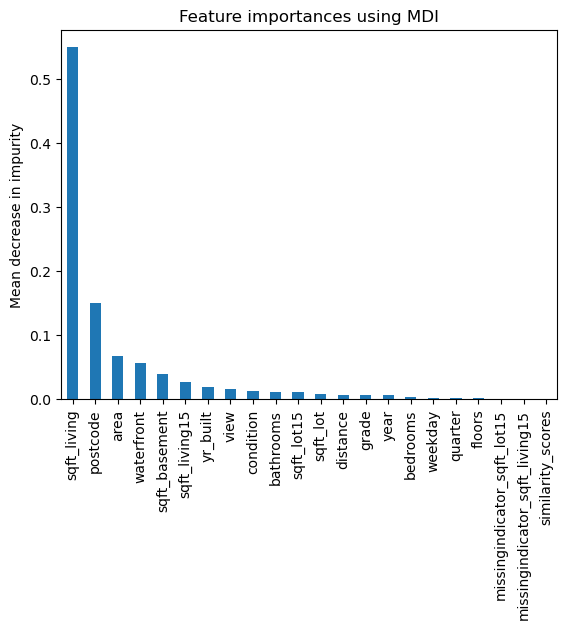

In [60]:
# Plot the feature importances
fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.show()

You should see the feature `sqft_living` is significantly more important than other features. 

<img src="./images/feature-importances.png" />

### 5c) Select only the most important features
In this exercise, you'll gain an intuition of how feature selection can affect model performance. Complete the `select_only_important_features` function. This function receives a Pandas Series holding feature importances, where the indexes of the Series are the feature names and the values the importance values (just like the `feature_importances` variable you created above). It then:
1. creates a loop where a given RandomForestRegressor model (`rfr_model`) is fitted on each iteration beginning with just the most important feature from `X_train`. Then, it increases the number of important features by one in each iteration so the model is trained with all the features at the end. In other words, it needs to train a model using the $i+1$ most important features of `X_train` in $i^{th}$ iteration (suppose i starts with zero). The function also needs to evaluate the model performance against the testing dataset (`X_test` and `y_test`) using $R^2$ score on each iteration and append the score to a list.
1. During the loop, the function should also keep track of the list of features that yields the best R2 score.
1. Finally, the function should return a tuple consisting of two lists: 1) the feature list that yields the best R2 score and 2) a list of the R2 scores obtained from each iteration.

In [61]:
def select_only_important_features(
    feature_importances: pd.Series,
    rfr_model: RandomForestRegressor,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | np.ndarray,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame | np.ndarray,
) -> Tuple[List[str], List[float]]:
    """
    Select the most important features iteratively and fit a model using those features.
    Args:
        feature_importances: A pandas Series holding the feature importances
        rfr_model: A RandomForestRegressor model to be fitted
        X_train: A pandas DataFrame holding the training features
        y_train: A pandas DataFrame or numpy array holding the training target values
        X_test: A pandas DataFrame holding the test features
        y_test: A pandas DataFrame or numpy array holding the test target values
    Returns:
        A tuple of a list of features that yields the best R2 score and the R2 scores obtained from each iteration
    """

    best_features = [] # keep track of the best features that yield the best R2 score
    r2_scores = [] # keep track of the R2 scores obtained from each iteration
    best_r2_score = 0 # keep track of the best R2 score obtained
    
    ### START CODE HERE
    # Sort feature importances in descending order to get the most important features first
    sorted_features = feature_importances.sort_values(ascending=False).index

    # Loop over the features, starting with the most important one
    for i in range(1, len(sorted_features) + 1):
        # Select the top i features
        selected_features = sorted_features[:i]

        # Train the model using the selected features
        rfr_model.fit(X_train[selected_features], y_train)

        # Make predictions on the test set
        y_pred = rfr_model.predict(X_test[selected_features])

        # Calculate the R2 score
        current_r2 = r2_score(y_test, y_pred)
        r2_scores.append(current_r2)

        # Update the best features if the current R2 score is higher
        if current_r2 > best_r2_score:
            best_r2_score = current_r2
            best_features = selected_features.tolist()

    ### END CODE HERE

    return best_features, r2_scores

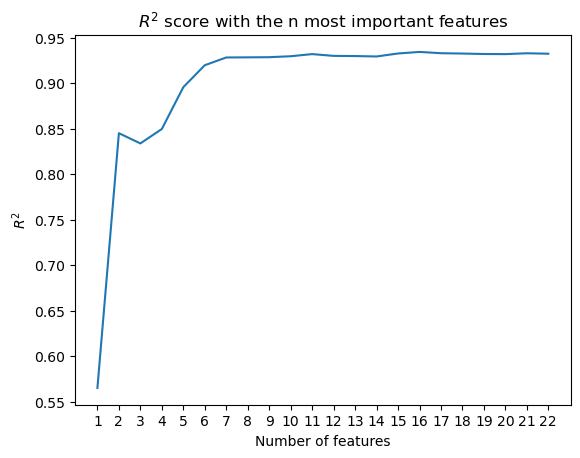

In [62]:
# Run the function using the feature-engineered data and plot the results
best_features, r2_scores = select_only_important_features(
    feature_importances, RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED), X_train, y_train, X_test, y_test
)
plt.plot(list(range(1, len(feature_importances) + 1)), r2_scores)
plt.xticks(list(range(1, len(X_train.columns) + 1)))
plt.title(r"$R^2$ score with the n most important features")
plt.xlabel("Number of features")
plt.ylabel(r"$R^2$")
plt.show()

In [63]:
# Check the results
optimal_number_of_features = len(best_features)
best_r2_score = min(r2_scores)

unimportant_features = [x for x in X_train.columns if x not in best_features]

assert optimal_number_of_features == 16, "The number of optimal features is incorrect."
assert set(best_features) == set(
    [
        "sqft_living",
        "postcode",
        "area",
        "waterfront",
        "sqft_basement",
        "sqft_living15",
        "yr_built",
        "view",
        "condition",
        "bathrooms",
        "sqft_lot15",
        "sqft_lot",
        "distance",
        "grade",
        "year",
        "bedrooms",
    ]
), "The best features that yield the best R2 score are incorrect."
assert set(unimportant_features) == set(
    [
        "floors",
        "similarity_scores",
        "missingindicator_sqft_living15",
        "missingindicator_sqft_lot15",
        "quarter",
        "weekday",
    ]
), "The unimportant features are incorrect."

We now know which features can result in the best $R^2$ score, let's implement the `drop_unimportant_features` that drop those unimportant columns.

In [64]:
def drop_unimportant_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Args:
        df (DataFrame): DataFrame from which the unimportant features should be dropped.
    Returns:
        DataFrame: a new DataFrame with the unimportant features dropped.
    """
    unimportant_features = [
        "floors",
        "similarity_scores",
        "missingindicator_sqft_living15",
        "missingindicator_sqft_lot15",
        "quarter",
        "weekday",
    ]
    ### START CODE HERE
    # Drop the unimportant features and return the modified DataFrame
    df_dropped = df.drop(columns=unimportant_features, errors='ignore')
    
    return df_dropped
    ### END CODE HERE

In [65]:
# Drop unimportant features
X_train = pd.read_parquet(housing_train_x_path)
X_test = pd.read_parquet(housing_test_x_path)
X_train_unimportant_features_dropped = drop_unimportant_features(X_train)
X_test_unimportant_features_dropped = drop_unimportant_features(X_test)

assert set(X_train_unimportant_features_dropped.columns) == set(
    [
        "sqft_living",
        "postcode",
        "area",
        "waterfront",
        "sqft_basement",
        "sqft_living15",
        "yr_built",
        "view",
        "condition",
        "bathrooms",
        "sqft_lot15",
        "sqft_lot",
        "distance",
        "grade",
        "year",
        "bedrooms",
    ]
), "The columns of the training set are incorrect after the unimportant features are dropped."

In [66]:
# Save only important features
store_features(X_train_unimportant_features_dropped, feature_store_path / "housing_train_X_important.parquet")
store_features(X_test_unimportant_features_dropped, feature_store_path / "housing_test_X_important.parquet")

To conclude Assignments 4 and 5, let's again wrap everything inside one function that will be responsible for feature engineering. The function takes the data that has been preprocessed and validated, extracts all of the features, and stores them into the feature store. It's worth noting that this function will not only be applied to training data but also to test data and production data. As a result, the following three scenarios need to be considered:
|dataset type|target included|fit a new target encoder|load a fitted target encoder|
|------------|---------------|------------------------|----------------------------|
|training|x|x||
|test|x||x|
|production|||x|

In [67]:
def feature_engineering_pipeline(df: pd.DataFrame, 
                                 feature_store_path: Path,
                                 feature_file_name: str, 
                                 encoder_file_name: str, 
                                 target_file_name: Optional[str]=None, 
                                 fit_encoder: bool=False, 
                                 targets_included: bool=True) -> None:
    """
    Converts a given (merged) housing data DataFrame into features and targets, performs feature engineering, and 
    stores the features along with possible targets and a fitted encoder
    Args:
        df (DataFrame): A pandas DataFrame holding all of the housing data, or just the features (see targets_included)
        feature_store_path (Path): Path of the feature store
        feature_file_name (str): Filename for the stored features.
        encoder_file_name (str): Filename for the stored encoder.
        target_file_name (str|None): Filename for the stored targets.
        fit_encoder (bool): Whether a new target encoder should be fitted. If False, uses a previously stored encoder
        targets_included (bool):  If True, df has all of the housing data including targets. If False, df has only the features.
    """
    if targets_included:
        X, y = separate_X_and_y(df, target='price')   
    else:
        if fit_encoder:
            raise ValueError("Target encoder can not be trained without targets.")

    X_missing_imputed_= impute_missing(X)
    X_datetime_decomposed = datetime_decomposer(X_missing_imputed_, dt_column_name='date')
    X_condition_encoded = condition_encoder(X_datetime_decomposed)
    X_unimportant_features_dropped = drop_unimportant_features(X_condition_encoded)

    feature_file_path = feature_store_path / feature_file_name
    target_file_path = feature_store_path / target_file_name
    encoder_file_path = feature_store_path / "encoders" / encoder_file_name

    if fit_encoder:
        t_encoder, X_target_encoded = target_encode(X_unimportant_features_dropped, columns=['postcode', 'area'], target=y)
        store_features(X_target_encoded, feature_file_path)
        store_targets(y, target_file_path)
        store_encoder(t_encoder, encoder_file_path)
        
    else:
        with open(encoder_file_path, 'rb') as enc_f:
            t_encoder = pickle.load(enc_f)
        _, X_target_encoded = target_encode(X_unimportant_features_dropped, columns=['postcode', 'area'], encoder=t_encoder)
        store_features(X_unimportant_features_dropped, feature_file_path)    
        if targets_included:
            store_targets(y, target_file_path)

## Assignment 6: One script to rule them all (2 points)

The jupyter notebook we have played with this far is a good tool for exploratory and iterative development, but contains all sort of redundant code, which is no longer needed once we want to push the finalized version into production. As a final wrap-up exercise, we'll collect all of the functionalities created in this assignment to a single streamlined `etl.py` module. The file `etl.py` already exists as a template with all the necessary imports and global variables. 

### 6a) Let's begin with copying the functions...

Copy the following functions to `etl.py`: file_reader, dataframe_merger, drop_futile_columns, correct_distance_unit, string_transformer, typo_fixer, data_extraction, batch_creator, create_checkpoint, separate_X_and_y, impute_missing, datetime_decomposer, condition_encoder, target_encode, store_features, store_targets, store_encoder, drop_unimportant_features, feature_engineering_pipeline. 

There are many ways you can achieve this. Here are three:
1. Just copy-paste each function (carefully).
1. Use jupyter cell magic. You can add the line `%%writefile -a etl.py` at the beginning of each cell that contains a function. Run each of these cells exactly once. This will append the cell content inside the `etl.py` file. The cells should not contain code outside the function definitions. Once you've done, remove the cell magic commands.
1. Use `jupyter nbconvert` function. For example, running the following command will copy all your Python code (while ignoring Markdown cells) to a Python script that has the same name as the notebook. You can then clean the exported Python script and copy needed code such as the code skeleton of the `etl` function from `etl.py`. (Remember to rename your script to `etl.py` once you're done, otherwise you'll encounter issues when running some of the following code cells.)
```bash
jupyter nbconvert --to python --PythonExporter.exclude_markdown=True --no-prompt <jupyter-botebook-name>.ipynb 
```
### 6b) ...and create a wrapper

Create a wrapper function `etl` that loads, merges, cleans, and validates the specified data, extract features, and save the features (and possibly targets) in the feature store. Specifically, the function needs to perform as follows:
- It first runs the `data_extraction` function, which will result in a merged, cleaned DataFrame. you can use the hard-coded `correct_condition_values=['poor', 'tolerable', 'satisfactory', 'good', 'excellent']` in the `data_extraction` function.
- Then it uses Great Expectations Checkpoint to validate the DataFrame produced by the `data_extraction` function (The `batch_creator` and `create_checkpoint` functions are useful here). You can assume that the Great Expectations Context and the Expectation Suite are already configured. The GX Context is available via `context = gx.get_context(context_root_dir=gx_context_root_dir)` where `gx_context_root_dir` is the directory that contains all your Great Expectations config, which is the `gx` directory in our case. 
- If some validations fails, a warning should be printed. The warning can be as simple as a sentence like "Some GX validations failed". Hint: Please refer to [here](https://docs.greatexpectations.io/docs/reference/api/checkpoint/types/checkpoint_result/checkpointresult_class/) on how to check whether a validation succeeds or not. 
- Finally, no matter whether or not the DataFrame passes all Expectations, the `etl` function should feature-engineer the DataFrame using the `feature_engineering_pipeline` function. 

You can see a detailed description of the parameters of the `etl` function in [etl.py](./etl.py). 

Remember to include the completed `etl.py` in your submission.

Now, let's import the `etl` function and use it to process data from 2016.

In [68]:
from etl import etl

params = {
        "path": WORKING_DIR / "data" / "2016",
        "gx_context_root_dir": WORKING_DIR / "gx",
        "gx_datasource_name": "housing_datasource", 
        "gx_checkpoint_name": "checkpoint_2016",
        "gx_expectation_suite_name": "housing_expectation_suite",
        "gx_run_name": "run_2016",
        "feature_store_path": WORKING_DIR / "feature_store",
        "feature_file_name": "2016_test_X.parquet",
        "encoder_file_name": "housing_target_encoder.pkl", 
        "target_file_name": "2016_test_y.csv", 
        "fit_encoder": False,
        "targets_included": True
    }
etl(**params)

You should see a warning telling that two Expectations failed. The failed Expectations are "expect_column_values_to_be_in_set" for the "area" column and "expect_column_values_to_be_between" for the "date" column. 

**Please attach the failed Expectations to your PDF file**, e.g., 

<img src="./images/failed-expectation-example.png" />

(Please note that the provided example doesn't show the failed validations for data from 2016. It just illustrates which parts of the Checkpoint result file should be included in the submitted PDF.)

Let's train a model using only the important features of the training set.

In [69]:
WORKING_DIR = Path.cwd()
feature_store_path = WORKING_DIR / "feature_store"
RANDOM_SEED = 42

train_X_important = pd.read_parquet(feature_store_path / "housing_train_X_important.parquet")
train_y = pd.read_csv(feature_store_path / "housing_train_y.csv").values.ravel()
housing_rfr2 = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED)
housing_rfr2.fit(train_X_important, train_y)

RandomForestRegressor(n_jobs=-1, random_state=42)

Then, evaluate the `housing_rfr2` model using data from 2016. 

In [70]:
X_test_2016 = pd.read_parquet(WORKING_DIR / "feature_store" / "2016_test_X.parquet")
y_test_2016 = pd.read_csv(WORKING_DIR / "feature_store" / "2016_test_y.csv")
r2_score = housing_rfr2.score(X_test_2016, y_test_2016)
print(f"Model's R2 score using data from 2016 as test data: {r2_score}")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/liupei/Desktop/engineering_of_ml_systems/exe_week2/week2_tutorials_assignments/week2_assignments/feature_store/2016_test_X.parquet'

Model's R2 score using data from 2016 as test data should be 0.92359378. 

## What to submit
- This Jupyter notebook
- etl.py
- The PDF file containing your screenshots for Assignments 3 and 6. 